# 1. Giới thiệu

Home credit là một cuộc thi phân tích dữ liệu do kaggle tổ chức. Đề tài cần giải quyết là một bài toán thuộc lớp mô hình phân loại và học có giám sát. Yêu cầu của các đội thi là xây dựng mô hình phân loại các hợp đồng tín dụng đã được gán nhãn repaid (trả nợ) và no repaid  (không trả nợ) sao cho mức độ chính xác trong phân loại là lớn nhất. Tiêu chí được sử dụng để đánh giá mô hình là chỉ số AUC, một chỉ số khá quen thuộc trong lĩnh vực scorecard. Về mặt toán học AUC chính là phần diện tích nằm dưới đường cong ROC mà giá trị của nó nằm trong khoảng từ [0, 1]. Một mô hình càng có sức mạnh phân loại tốt khi AUC càng gần 1 và trái lại. Trường hợp AUC = 0.5 kết quả mô hình bằng với việc dự báo ngẫu nhiên. AUC < 0.5 đảo ngược kết quả của mô hình bạn sẽ thu được một mô hình mạnh hơn.

Đây là một bài toán thuộc lĩnh vực credit risk được sử dụng nhiều trong các tổ chức tài chính, ngân hàng. Chính vì vai trò và mức độ quan trọng của bài toán nên Home Credit thu hút được trên 7000 đội tham dự. Dữ liệu của bài toán thuộc dạng có cấu trúc (SQL) gồm nhiều bảng liên hệ với nhau bởi các primary key và foriegn key theo sơ đồ bên dưới:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Các bảng dữ liệu bao quát các khía cạnh của một hồ sơ tín dụng như:

* Thông tin hồ sơ khách hàng hiện tại: Mỗi một hồ sơ được xác định bằng một khóa SK_ID_CURR. Trong thông tin hồ sơ chúng ta sẽ biết được thu nhập, số lượng người phụ thuộc, nghề nghiệp, trình độ giáo dục, ngày sinh, có sở hữu xe hay không,.... và rất nhiều các thông tin khác. Các thông tin này có thể chia thành nhóm nhân khẩu học (demographic) liên quan đến cá nhân vay và thông tin tín dụng liên quan đến tình trạng tín dụng của người vay. Các bảng application_train.csv (sử dụng để huấn luyện) và bảng application_test.csv (sử dụng để test). Về mặt cấu trúc các trường trong bảng application_train.csv và application_test.csv là giống nhau ngoại trừ biến mục tiêu TARGET được giấu ở application_test.csv để đánh giá kết quả mô hình sau cùng.

* Thông tin giao dịch: Các lịch sử giao dịch và hành vi mua sắm qua thẻ tín dụng của người tiêu dùng tại home credit. Bảng POSH_CASH_balance.csv

* Thông tin trả nợ: Lịch sử trả nợ của khách hàng trong quá khứ nếu họ đã có các khoản vay trước đó tại home credit. Bảng installments_payment.csv

* Thông tin hồ sơ các khoản vay trước đây tại home credit. Bảng previous_application.csv

* Thông tin các khoản vay tại tổ chức tài chính khác được lưu trữ tại cục tín dụng. Bảng bureau_balance.csv và bureau.csv.

# 2. Tiền xử lý dữ liệu

Do dữ liệu home credit được chia thành nhiều khía cạnh dữ liệu nhỏ và quản lý tại mỗi bảng riêng biệt nên ta cần thống kê các thông tin của dữ liệu theo key là ID hồ sơ và join các thông tin thu được từ mỗi bảng theo key để thu được bảng tổng hợp làm input cho mô hình. Tại bước này chúng ta cần các kĩ năng về data manipulation trên pandas. Cụ thể bạn đọc có thể tham khảo thêm hướng dẫn xử lý dữ liệu với [pandas](https://www.kaggle.com/phamdinhkhanh/gi-i-thi-u-pandas).

Một điểm cần lưu ý đó là thông tin về các hồ sơ tín dụng thường không đầy đủ. Do đó chúng ta cần kiểm tra tỷ lệ các quan sát bị missing ở mỗi trường. Việc kiểm tra tỷ lệ missing giúp đánh giá mức độ đầy đủ về mặt thông tin mà một trường dữ liệu cung cấp. Khi tỷ lệ missing quá lớn, trường dữ liệu thường không đáng tin cậy trong phân loại mô hình và chúng ta cần phải loại những biến này khỏi mô hình.

## 2.1. Khảo sát dữ liệu

Bên dưới ta sẽ kiểm tra số trường và kích thước mẫu của các tập dữ liệu train và test.

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import seaborn as sns

%matplotlib inline

# Checking for all file
os.listdir('../input')

['bureau_balance.csv',
 'application_test.csv',
 'installments_payments.csv',
 'application_train.csv',
 'POS_CASH_balance.csv',
 'sample_submission.csv',
 'bureau.csv',
 'credit_card_balance.csv',
 'previous_application.csv']

In [2]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Biến TARGET của tập test đã được giấu đi để đánh giá mô hình được xây dựng từ tập train. Số lượng quan sát của train lớn gấp khoảng 6 lần train. 

Bên dưới ta sẽ thống kê số lượng và tỷ lệ các class Repaid và Not repaid trong tập train.

Repaid: 282686
Not repaid: 24825
Repaid: 91.93 %
Not repaid: 8.07 %


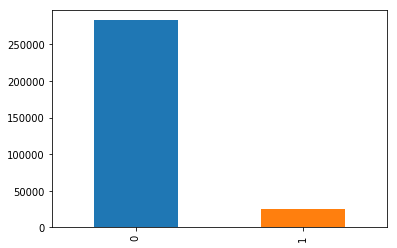

In [4]:
app_train['TARGET'].value_counts().plot.bar()
n_group = app_train['TARGET'].value_counts()
n_group_sum = n_group.sum()

print('Repaid: {}'.format(n_group[0]))
print('Not repaid: {}'.format(n_group[1]))

print('Repaid: {:.2f} {}'.format(n_group[0]/n_group_sum*100, '%'))
print('Not repaid: {:.2f} {}'.format(n_group[1]/n_group_sum*100, '%'))

Mẫu có hiện tượng mất cân bằng khi nhóm thiểu chỉ chiếm 8.07% và nhóm đa số chiếm tới 91.93%. Mẫu mất cân bằng có thể dẫn tới một số tác hại đối với mô hình như:

1. Kết quả dự báo của mô hình chỉ thiên về một class. Thậm chí trong một số trường hợp mô hình dự báo chỉ đưa ra một class duy nhất là class đa số.
2. Dễ dàng ngộ nhận mô hình tốt do Accuracy của mô hình đối với mẫu mất cân bằng thường rất cao. Trong trường hợp này ta cần sử dụng đến các chỉ số thay thế như precision, recall, F1-Score, Kappa, ROC Curve. Về nội dung và ý nghĩa của các chỉ số này các bạn có thể tham khảo tại [đánh giá hệ thống phân lớp](https://machinelearningcoban.com/2017/08/31/evaluation/).

Khi gặp hiện tượng mất cân bằng mẫu chúng ta có thể sử dụng nhiều phương pháp khác nhau để biến đổi mẫu về cân bằng. Một trong những phương pháp đó là:

1.	Thu thập thêm nhiều dữ liệu cho mẫu thiểu số nếu việc thu thập thêm dữ liệu là khả thi trên thực tế.
2.	Sử dụng các phương pháp tái chọn mẫu có lặp lại (resampling) nhằm gia tăng số lượng mẫu thiểu số.
3.	Sử dụng kĩ thuật tạo mẫu tổng hợp cho mẫu thiểu (Synthetic Minority Over-sampling Technique - SMOTE). Thay vì lấy các quan sát lập lại, thuật toán sẽ tạo ra các quan sát tổng hợp dựa trên hai hoặc nhiều quan sát mẫu. Các mẫu được lựa chọn có sự tương đương nhau dựa trên thước đo khoảng cách. Các thuộc tính của quan sát tổng hợp sau đó sẽ được tạo ra bằng cách thêm một đại lượng ngẫu nhiên chênh lệch so với các điểm lân cận.
4.	Thêm các hệ số phạt vào mô hình để gia tăng hàm mất mát nhiều hơn nếu dự báo sai các mẫu thiểu. 

Bên dưới ta sẽ thống kê dữ liệu missing và các kiểu dữ liệu numeric, categorical.

In [5]:
def summary_missing(dataset):
    n_miss = dataset.isnull().sum()
    n_obs = dataset.shape[0]
    n_miss_per = n_miss/n_obs*100
    n_miss_tbl = pd.concat([n_miss, n_miss_per], axis = 1).sort_values(1, ascending = False).round(1)
    n_miss_tbl = n_miss_tbl[n_miss_tbl[1] != 0]
    print('No fields: ', dataset.shape[0])
    print('No missing fields: ', n_miss_tbl.shape[0])
    n_miss_tbl = n_miss_tbl.rename(columns = {0:'Number mising Value', 1:'Percentage missing Value'})
    return n_miss_tbl

summary_missing(app_train)

No fields:  307511
No missing fields:  64


,Number mising Value,Percentage missing Value
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4


In [6]:
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(app_train)
table_dtype

,Data Type
SK_ID_CURR,int64
FLAG_CONT_MOBILE,int64
FLAG_PHONE,int64
FLAG_EMAIL,int64
FLAG_DOCUMENT_9,int64
FLAG_DOCUMENT_8,int64
REGION_RATING_CLIENT,int64
REGION_RATING_CLIENT_W_CITY,int64
FLAG_DOCUMENT_7,int64
REG_REGION_NOT_LIVE_REGION,int64


In [7]:
table_dtype['Data Type'].value_counts()

float64    65
int64      41
object     16
Name: Data Type, dtype: int64

In [8]:
# Các dòng dữ liệu dạng object
app_train.select_dtypes('object').head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


Thống kê số lượng các class trong mỗi nhóm đối với dữ liệu dạng object.

In [9]:
app_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Vẽ biểu đồ phân phối số lượng các quan sát theo nhóm đối với dữ liệu dạng object. Đối với các biến ORGANIZATION_TYPE, OCCUPATION_TYPE ta sẽ nghiên cứu riêng do số lượng class lớn.

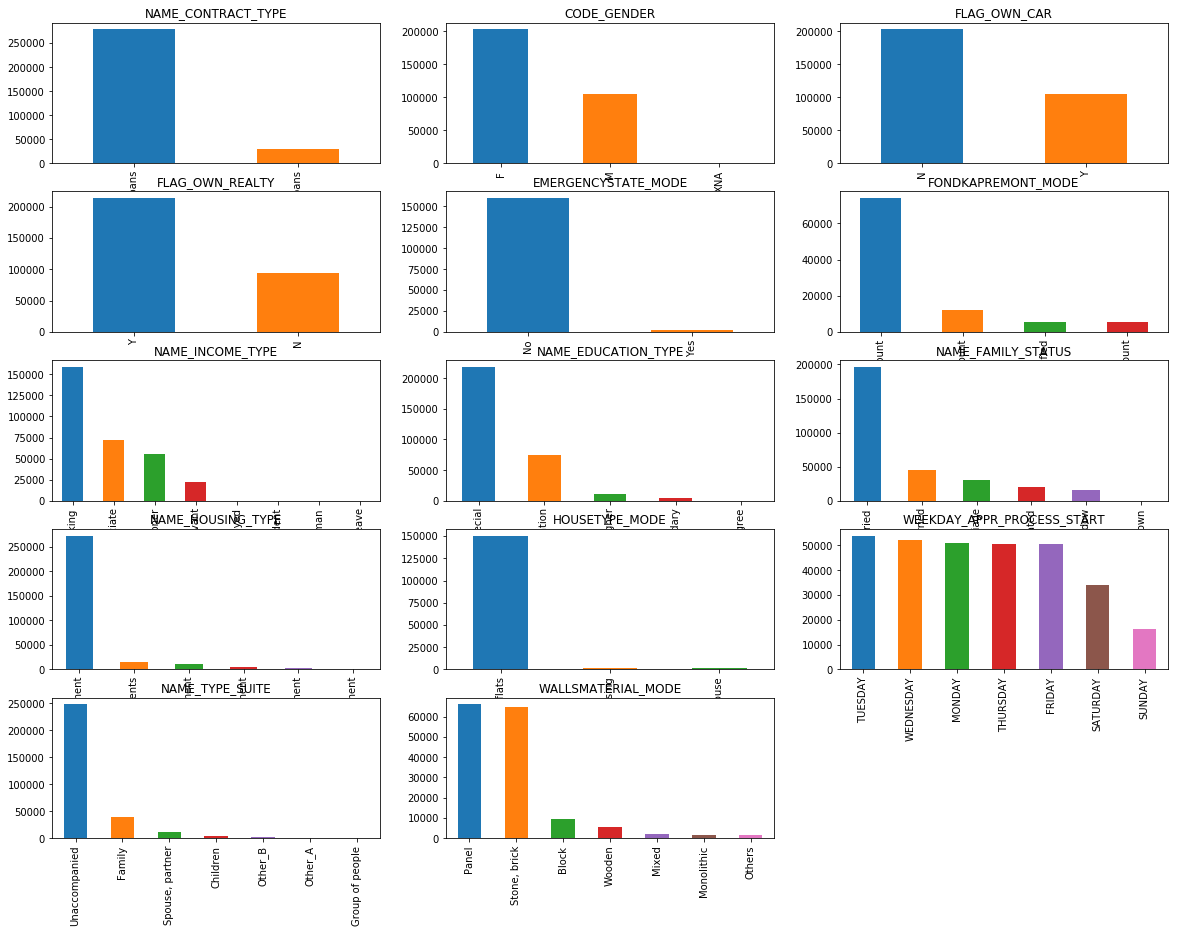

In [10]:
dtypes_object = table_dtype[table_dtype['Data Type'] == 'object'].index.tolist()
dtypes_object = [col for col in dtypes_object if col not in ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']]


def _plot_bar_classes(cols):
    app_train[cols].value_counts().plot.bar()

plt.figure(figsize = (20, 15))    
for i in range(1, 15, 1):
    plt.subplot(5, 3, i)
    _plot_bar_classes(dtypes_object[i-1])
    plt.title(dtypes_object[i-1])

Thống kê tỷ lệ Repaid/Not Repaid theo các biến dự báo dạng object.

In [11]:
def _per_categorical(col):
    tbl_per = pd.pivot_table(app_train[['TARGET', col]], index = ['TARGET'], columns = [col], aggfunc = len)
    per_categorical = (tbl_per.iloc[0, :]/tbl_per.iloc[1, :]).sort_values(ascending = True)
    print(per_categorical)
    print('-------------------------------------\n')
    return per_categorical

for col in dtypes_object:
    _per_categorical(col)

NAME_CONTRACT_TYPE
Cash loans         10.981913
Revolving loans    17.253741
dtype: float64
-------------------------------------

CODE_GENDER
M       8.860066
F      13.287085
XNA          NaN
dtype: float64
-------------------------------------

FLAG_OWN_CAR
N    10.764392
Y    12.805042
dtype: float64
-------------------------------------

FLAG_OWN_REALTY
N    11.012114
Y    11.560325
dtype: float64
-------------------------------------

EMERGENCYSTATE_MODE
Yes     9.439462
No     13.357709
dtype: float64
-------------------------------------

FONDKAPREMONT_MODE
not specified            12.256410
reg oper account         13.330357
reg oper spec account    14.252525
org spec account         16.183486
dtype: float64
-------------------------------------

NAME_INCOME_TYPE
Maternity leave          1.500000
Unemployed               1.750000
Working                  9.429191
Commercial associate    12.361381
State servant           16.376301
Pensioner               17.565392
Businessman  

Vẽ biểu đồ tỷ lệ Repaid/Not Repaid theo các biến dự báo dạng object.

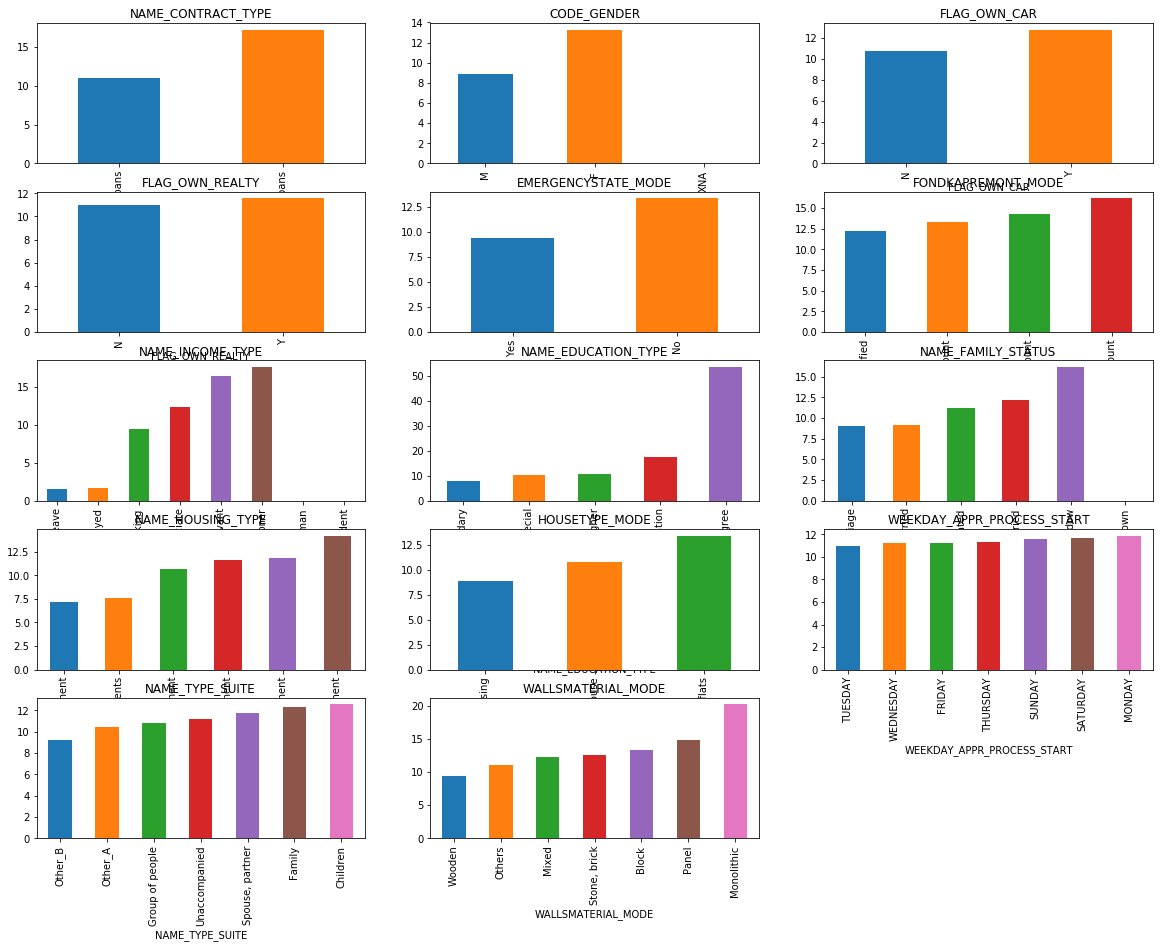

In [12]:
def _plot_per_categorical(col):
    tbl_per = pd.pivot_table(app_train[['TARGET', col]], index = ['TARGET'], columns = [col], aggfunc = len)
    per_categorical = (tbl_per.iloc[0, :]/tbl_per.iloc[1, :]).sort_values(ascending = True)
    per_categorical.plot.bar()
    plt.title(col)
    return per_categorical

plt.figure(figsize = (20, 15))
i = 0
for col in dtypes_object:
    i += 1
    plt.subplot(5, 3, i)
    _plot_per_categorical(col)

Thông qua biểu đồ ta cũng hình dung được một vài biến phân loại có sự khác biệt lớn giữa tỷ lệ Repaid/Non Repaid lớn như NAME_CONTRACT_TYPE, GENDER, FLAG_OWN_REALITY do đó đây là những biến có tác động lớn đến biến mục tiêu.

Kiểm tra riêng cho 2 biến ORGANIZATION_TYPE, OCCUPATION_TYPE.

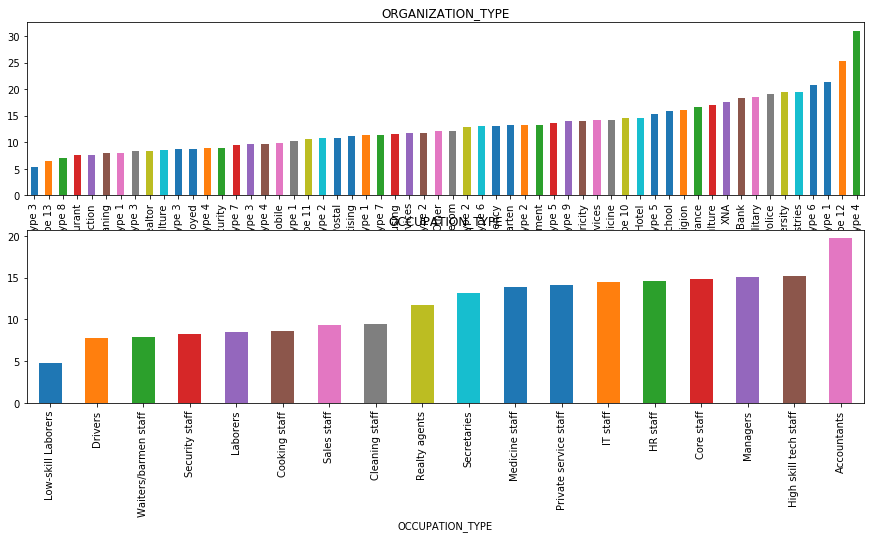

In [13]:
plt.figure(figsize = (15, 7))
i = 0
for col in ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']:
    i += 1
    plt.subplot(2, 1, i)
    _plot_per_categorical(col)

## 2.2. Nhóm các đặc trưng theo tỷ lệ Repaid/Not Repaid
Để giảm thiểu số lượng đặc trưng (features) ta có thể nhóm những biến có tỷ lệ Repaid/Not Repaid gần bằng nhau vào một nhóm bởi những nhóm này có đặc tính gần giống nhau trong phân loại hợp đồng.

In [14]:
for col in ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']:
    _per_categorical(col)

ORGANIZATION_TYPE
Transport: type 3          5.347594
Industry: type 13          6.444444
Industry: type 8           7.000000
Restaurant                 7.542453
Construction               7.561783
Cleaning                   7.965517
Industry: type 1           8.034783
Industry: type 3           8.419540
Realtor                    8.428571
Agriculture                8.548638
Trade: type 3              8.673130
Self-employed              8.829069
Industry: type 4           8.853933
Security                   9.021605
Trade: type 7              9.582432
Business Entity Type 3     9.753124
Transport: type 4          9.774451
Mobile                     9.931034
Trade: type 1             10.225806
Industry: type 11         10.555556
Business Entity Type 2    10.725556
Postal                    10.851648
Advertising               11.257143
Business Entity Type 1    11.287474
Industry: type 7          11.447619
Housing                   11.587234
Legal Services            11.708333
Transport:

In [15]:
# Nhóm các giá trị rate gần bằng nhau vào 1 nhóm theo schedule_div.
def _devide_group(col, schedule_div = None, n_groups = 3, *kwargs):
    cols = []
    tbl_per_cat = _per_categorical(col)
    
    if schedule_div is None:
        n_cats = len(tbl_per_cat)
        n_val_incat = int(n_cats/n_groups)
        n_odd = n_cats - n_groups*n_val_incat

        for i in range(n_groups):
            if i == n_groups - 1:
                el = tbl_per_cat[(n_val_incat*i):(n_val_incat*(i+1)+n_odd)].index.tolist()
            else:
                el = tbl_per_cat[(n_val_incat*i):n_val_incat*(i+1)].index.tolist()    
            cols.append(el)
    else:
        idx = 0
        for n_cols in schedule_div:
            el_cols = tbl_per_cat[idx:(idx+n_cols)].index.tolist()
            cols.append(el_cols)
            idx += n_cols
                
    return cols

cols_OCCUPATION_TYPE = _devide_group(col = 'OCCUPATION_TYPE', schedule_div = [1, 7, 9, 1])
cols_OCCUPATION_TYPE

OCCUPATION_TYPE
Low-skill Laborers        4.830084
Drivers                   7.829141
Waiters/barmen staff      7.868421
Security staff            8.308864
Laborers                  8.452895
Cooking staff             8.574879
Sales staff               9.382277
Cleaning staff            9.409396
Realty agents            11.728814
Secretaries              13.184783
Medicine staff           13.924825
Private service staff    14.154286
IT staff                 14.470588
HR staff                 14.638889
Core staff               14.863061
Managers                 15.092620
High skill tech staff    15.233951
Accountants              19.702532
dtype: float64
-------------------------------------



[['Low-skill Laborers'],
 ['Drivers',
  'Waiters/barmen staff',
  'Security staff',
  'Laborers',
  'Cooking staff',
  'Sales staff',
  'Cleaning staff'],
 ['Realty agents',
  'Secretaries',
  'Medicine staff',
  'Private service staff',
  'IT staff',
  'HR staff',
  'Core staff',
  'Managers',
  'High skill tech staff'],
 ['Accountants']]

In [16]:
cols_ORGANIZATION_TYPE = _devide_group(col = 'ORGANIZATION_TYPE')
cols_ORGANIZATION_TYPE

ORGANIZATION_TYPE
Transport: type 3          5.347594
Industry: type 13          6.444444
Industry: type 8           7.000000
Restaurant                 7.542453
Construction               7.561783
Cleaning                   7.965517
Industry: type 1           8.034783
Industry: type 3           8.419540
Realtor                    8.428571
Agriculture                8.548638
Trade: type 3              8.673130
Self-employed              8.829069
Industry: type 4           8.853933
Security                   9.021605
Trade: type 7              9.582432
Business Entity Type 3     9.753124
Transport: type 4          9.774451
Mobile                     9.931034
Trade: type 1             10.225806
Industry: type 11         10.555556
Business Entity Type 2    10.725556
Postal                    10.851648
Advertising               11.257143
Business Entity Type 1    11.287474
Industry: type 7          11.447619
Housing                   11.587234
Legal Services            11.708333
Transport:

[['Transport: type 3',
  'Industry: type 13',
  'Industry: type 8',
  'Restaurant',
  'Construction',
  'Cleaning',
  'Industry: type 1',
  'Industry: type 3',
  'Realtor',
  'Agriculture',
  'Trade: type 3',
  'Self-employed',
  'Industry: type 4',
  'Security',
  'Trade: type 7',
  'Business Entity Type 3',
  'Transport: type 4',
  'Mobile',
  'Trade: type 1'],
 ['Industry: type 11',
  'Business Entity Type 2',
  'Postal',
  'Advertising',
  'Business Entity Type 1',
  'Industry: type 7',
  'Housing',
  'Legal Services',
  'Transport: type 2',
  'Other',
  'Telecom',
  'Industry: type 2',
  'Industry: type 6',
  'Emergency',
  'Kindergarten',
  'Trade: type 2',
  'Government',
  'Industry: type 5',
  'Industry: type 9'],
 ['Electricity',
  'Services',
  'Medicine',
  'Industry: type 10',
  'Hotel',
  'Trade: type 5',
  'School',
  'Religion',
  'Insurance',
  'Culture',
  'XNA',
  'Bank',
  'Military',
  'Police',
  'University',
  'Security Ministries',
  'Trade: type 6',
  'Transpo

Sau khi đã nhóm các features trong một biến phân loại thành các features tổng hợp chúng ta cần cập nhật lại các trường của bảng dữ liệu theo các features mới.

In [17]:
def _map_lambda_cats(cols_list, colname, x): 
    cats = list(map(lambda x:colname + '_' + str(x), np.arange(len(cols_list)).tolist()))
    for i in range(len(cols_ORGANIZATION_TYPE)):
        if x in cols_list[i]:
            return cats[i]
        
def _map_cats(cols_list, colname, dataset):                    
    return list(map(lambda x: _map_lambda_cats(cols_list, colname, x), 
                    dataset[colname]))

app_train['ORGANIZATION_TYPE'] = _map_cats(cols_ORGANIZATION_TYPE, 'ORGANIZATION_TYPE', app_train)
pd.Series.unique(app_train['ORGANIZATION_TYPE'])

array(['ORGANIZATION_TYPE_0', 'ORGANIZATION_TYPE_2',
       'ORGANIZATION_TYPE_1'], dtype=object)

Áp dụng trên tập test.

In [18]:
app_test['ORGANIZATION_TYPE'] = _map_cats(cols_ORGANIZATION_TYPE, 'ORGANIZATION_TYPE', app_test)
pd.Series.unique(app_test['ORGANIZATION_TYPE'])

array(['ORGANIZATION_TYPE_1', 'ORGANIZATION_TYPE_0',
       'ORGANIZATION_TYPE_2'], dtype=object)

Gán lại các biến này bằng dữ liệu sau khi map.

In [19]:
app_train['OCCUPATION_TYPE'] = _map_cats(cols_OCCUPATION_TYPE, 'OCCUPATION_TYPE', app_train)
app_test['OCCUPATION_TYPE'] = _map_cats(cols_OCCUPATION_TYPE, 'OCCUPATION_TYPE', app_test)

Sau các xử lý trên, dữ liệu trên app_train và app_test sẽ được map theo các nhóm phân loại mới. Chúng ta có thể kiểm tra lại tỷ lệ Repaid/No Repaid của các nhóm biến mới như bên dưới.

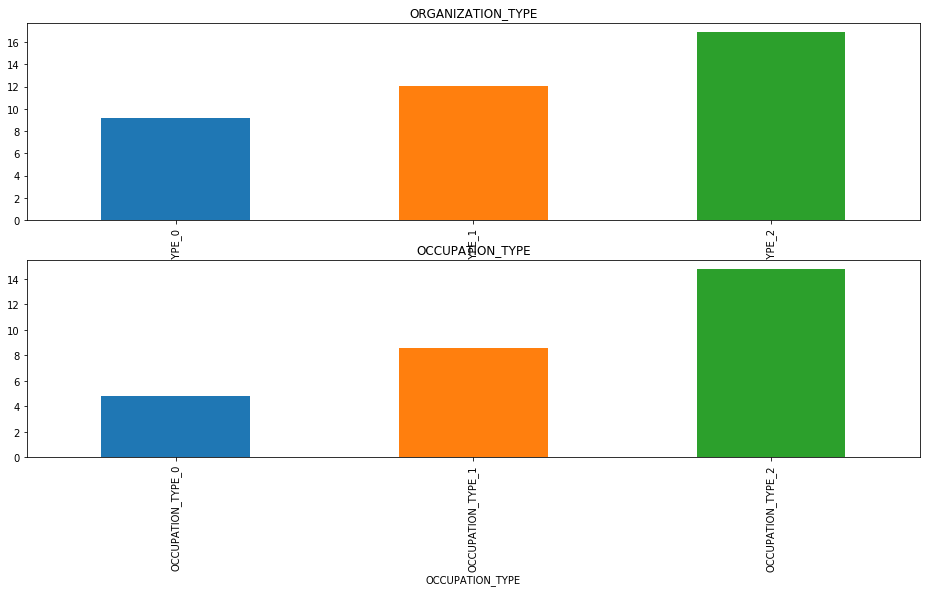

In [20]:
i = 0
plt.figure(figsize = (16, 8))
for col in ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']:
    i += 1
    plt.subplot(2, 1, i)
    _plot_per_categorical(col)

Sau khi đã nhóm xong các biến category thành những features tổng hợp, chúng ta cần biến đổi các biến này sao cho chúng có thể được sử dụng trong mô hình hồi qui. Có 2 cách biến đổi chính có thể áp dụng đó là one-hot coding và tạo biến thứ bậc. Tạo biến thứ bậc thường được áp dụng khi các nhóm có sự khác biệt về mức độ chẳng hạn như xếp hạng học lực: Giỏi, Khá, Trung bình, Yếu. Trong khi đó one-hot coding sẽ biểu diễn một biến category bởi một vector sparse (các phần tử của vector là 0 hoặc 1) có độ dài bằng số lượng các nhóm sao cho đặc trưng tương ứng với giá trị của biến sẽ được gán là 1 và các đặc trưng còn lại là 0. Chúng ta có thể sử dụng hàm `get_dummies()` trong pandas để tự động biến đổi các biến category trong data frame về dạng one-hot coding.

In [21]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

Kiểm tra kích thước dữ liệu sau biến đổi.

In [22]:
print('app_train shape: ', app_train.shape)
print('app_test shape: ', app_test.shape)

app_train shape:  (307511, 176)
app_test shape:  (48744, 172)


Số lượng các biến đã tăng lên do biến đổi one-hot coding, tuy nhiên có sự chênh lệch giữa tập train và test. Kiểm tra các biến ở app_train không có trong app_test.

In [23]:
for fea_name in app_train.columns:
    if fea_name not in app_test.columns:
        print(fea_name)

TARGET
CODE_GENDER_XNA
NAME_INCOME_TYPE_Maternity leave
NAME_FAMILY_STATUS_Unknown


Những biến này không xuất hiện trong tập test là do có một số biến không xảy ra đầy đủ các khả năng. Chúng ta cần loại bỏ những biến không có trong tập train. Chỉ dữ lại những biến có trong cả app_train và app_test:

In [24]:
TARGET = app_train['TARGET']

# Lệnh align theo axis = 1 sẽ lấy những trường xuất hiện đồng thời trong app_train và app_test
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
# Sau lệnh align biến TARGET bị mất, do đó ta cần gán lại biến này
app_train['TARGET'] = TARGET

print('app_train shape: ', app_train.shape)
print('app_test shape: ', app_test.shape)

app_train shape:  (307511, 173)
app_test shape:  (48744, 172)


## 2.3. Xử lý outlier

Trong một bộ dữ liệu thường có những quan sát bất thường. Nguyên nhân có thể đến từ dữ liệu bị sai định dạng, quá trình nhập liệu sai, quan sát có tính chất đặc biệt,.... Việc tra soát các dữ liệu bất thường có thể giúp khám phá ra một số tình chất của dữ liệu và đồng thời hiệu chỉnh dữ liệu trong trường hợp nhập liệu sai. Kiếm tra dữ liệu bất thường có thể được thực hiện bằng các thống kê mô tả.

In [25]:
app_train.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_OCCUPATION_TYPE_0,OCCUPATION_TYPE_OCCUPATION_TYPE_1,OCCUPATION_TYPE_OCCUPATION_TYPE_2,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ORGANIZATION_TYPE_0,ORGANIZATION_TYPE_ORGANIZATION_TYPE_1,ORGANIZATION_TYPE_ORGANIZATION_TYPE_2,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,...,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,...,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


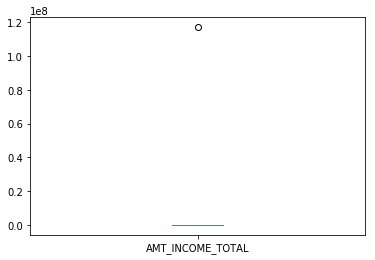

In [26]:
app_train['AMT_INCOME_TOTAL'].describe().plot.box()

Ta nhận thấy biến thu nhập có dấu hiệu bất thường dữ liệu khi hầu hết các khoảng ngũ phân vị (quintile) của biến đều thấp quan gốc 0 ngoại trừ một vài trường hợp cao đặc biệt. Điều này cho thấy có sự chênh lệch trong mức thu nhập của những người đi vay.

In [27]:
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

Giá trị cao nhất của thu nhập là khoảng 117 triệu USD trong khi trung bình thu nhập chỉ là 168 nghìn USD. Chúng ta sẽ kiểm tra phân phối của biến TARGET theo biến AMT_INCOME_TOTAL ứng với các trường hợp Repaid và No repaid.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


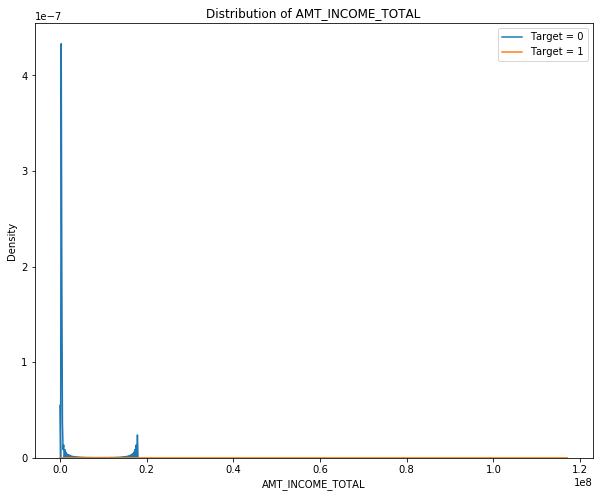

In [28]:
def _plot_density(colname):
    plt.figure(figsize = (10, 8))
    sns.kdeplot(app_train[colname][app_train['TARGET'] == 0], label = 'Target = 0')
    sns.kdeplot(app_train[colname][app_train['TARGET'] == 1], label = 'Target = 1')
    plt.xlabel(colname)
    plt.ylabel('Density')
    plt.title('Distribution of %s'%colname)

_plot_density('AMT_INCOME_TOTAL')

Sử dụng phương pháp 3 sigma để điều chỉnh lại các giá trị nằm ngoài miền $[\mu - 3\sigma, \mu + 3\sigma]$ về trong miền giá trị đó. Đối với giá trị lớn hơn $\mu+3\sigma$ sẽ được gán bằng $\mu+3\sigma$ và tương tự với giá trị nhỏ hơn $\mu - 3\sigma$. Phương pháp này giúp điều chỉnh các outlier về trong khoảng biến thiên cho phép và làm giảm ảnh hưởng chệch gây ra bởi chúng.

In [29]:
def _zoom_3sigma(col, dataset, dataset_apl):
    '''
    col: Tên cột dữ liệu
    dataset: Bảng dữ liệu gốc sử dụng để tính khoảng 3 sigma
    dataset_apl: Bảng dữ liệu mới áp dụng khoảng 3 sigma được lấy từ dataset.
    '''
    xs = dataset[col]
    mu = xs.mean()
    sigma = xs.std()
    low =  mu - 3*sigma
#     low =  0 if low < 0 else low
    high = mu + 3*sigma
    
    def _value(x):
        if x < low: return low
        elif x > high: return high
        else: return x
    xapl = dataset_apl[col]    
    xnew = list(map(lambda x: _value(x), xapl))
    n_low = len([i for i in xnew if i == low])
    n_high = len([i for i in xnew if i == high])
    n = len(xapl)
    print('Percentage of low: {:.2f}{}'.format(100*n_low/n, '%'))
    print('Percentage of high: {:.2f}{}'.format(100*n_high/n, '%'))
    print('Low value: {:.2f}'.format(low))
    print('High value: {:.2f}'.format(high))
    return xnew

# Kiểm tra với biến FLAG_MOBIL
x = _zoom_3sigma('FLAG_MOBIL', app_train, app_train)    

Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: 0.99
High value: 1.01


In [30]:
app_train.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [31]:
# Thống kê các giá trị khác biệt trong toàn bộ các biến.
def _count_unique(x):
    return pd.Series.nunique(x)

tbl_dis_val = app_train.apply(_count_unique).sort_values(ascending = False)
tbl_dis_val[tbl_dis_val > 500]

SK_ID_CURR                307511
EXT_SOURCE_2              119831
EXT_SOURCE_1              114584
DAYS_BIRTH                 17460
DAYS_REGISTRATION          15688
AMT_ANNUITY                13672
DAYS_EMPLOYED              12574
DAYS_ID_PUBLISH             6168
AMT_CREDIT                  5603
LIVINGAREA_MODE             5301
LIVINGAREA_MEDI             5281
LIVINGAREA_AVG              5199
TOTALAREA_MODE              5116
BASEMENTAREA_MODE           3841
BASEMENTAREA_AVG            3780
DAYS_LAST_PHONE_CHANGE      3773
BASEMENTAREA_MEDI           3772
LANDAREA_MODE               3563
LANDAREA_MEDI               3560
LANDAREA_AVG                3527
NONLIVINGAREA_MODE          3327
NONLIVINGAREA_MEDI          3323
NONLIVINGAREA_AVG           3290
COMMONAREA_MEDI             3202
COMMONAREA_AVG              3181
COMMONAREA_MODE             3128
AMT_INCOME_TOTAL            2548
APARTMENTS_AVG              2339
LIVINGAPARTMENTS_AVG        1868
APARTMENTS_MEDI             1148
LIVINGAPAR

Ta coi các biến có số lượng giá trị khác biệt > 500 là các biến liên tục. Áp dụng nguyên lý 3 sigma cho các biến này.

In [32]:
cols_3sigma = tbl_dis_val[tbl_dis_val > 500].index.tolist()
# Loại bỏ biến key là SK_ID_CURR ra khỏi danh sách:
cols_3sigma = cols_3sigma[1:]

In [33]:
# Loại bỏ các outlier bằng 3 sigma
for col in cols_3sigma:
    print(col)
    app_train[col] = _zoom_3sigma(col, app_train, app_train) 
    print('------------------------\n')

EXT_SOURCE_2
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -0.06
High value: 1.09
------------------------

EXT_SOURCE_1
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -0.13
High value: 1.14
------------------------

DAYS_BIRTH
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -29128.96
High value: -2945.03
------------------------

DAYS_REGISTRATION
Percentage of low: 0.24%
Percentage of high: 0.00%
Low value: -15554.78
High value: 5582.54
------------------------

AMT_ANNUITY
Percentage of low: 0.00%
Percentage of high: 0.96%
Low value: -16372.64
High value: 70589.79
------------------------

DAYS_EMPLOYED
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -360012.25
High value: 487642.35
------------------------

DAYS_ID_PUBLISH
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -7522.55
High value: 1534.15
------------------------

AMT_CREDIT
Percentage of low: 0.00%
Percentage of high: 1.06%
Low value: -608446.33
Hig

In [34]:
for col in cols_3sigma:
    print(col)
    app_test[col] = _zoom_3sigma(col, app_train, app_test) 
    print('------------------------\n')

EXT_SOURCE_2
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -0.06
High value: 1.09
------------------------

EXT_SOURCE_1
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -0.13
High value: 1.14
------------------------

DAYS_BIRTH
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -29128.96
High value: -2945.03
------------------------

DAYS_REGISTRATION
Percentage of low: 0.27%
Percentage of high: 0.00%
Low value: -15522.33
High value: 5555.90
------------------------

AMT_ANNUITY
Percentage of low: 0.00%
Percentage of high: 2.06%
Low value: -14129.39
High value: 68009.91
------------------------

DAYS_EMPLOYED
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -360012.25
High value: 487642.35
------------------------

DAYS_ID_PUBLISH
Percentage of low: 0.00%
Percentage of high: 0.00%
Low value: -7522.55
High value: 1534.15
------------------------

AMT_CREDIT
Percentage of low: 0.00%
Percentage of high: 1.82%
Low value: -574250.33
Hig

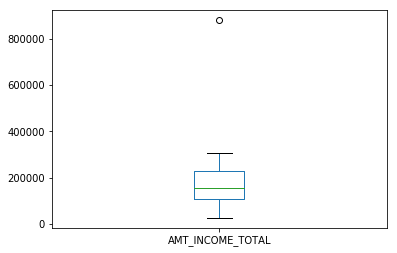

In [35]:
# Kiểm tra lại biến AMT_INCOME_TOTAL sau khi loại bỏ outlier
app_train['AMT_INCOME_TOTAL'].describe().plot.box()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


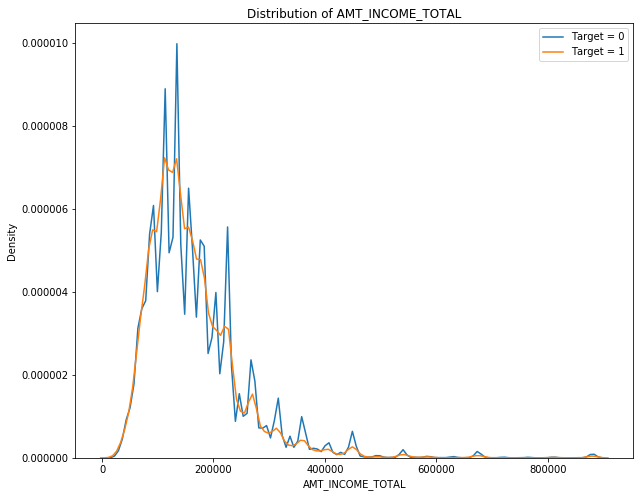

In [36]:
_plot_density('AMT_INCOME_TOTAL')

Như vậy sau khi loại bỏ oulier, đồ thị phân phối của AMT_INCOME_TOTAL đã không còn thiên lệch. Các điểm mốc Q1, Q2, Q3, Q4 trong tứ phân vị (quintile) đã không quá nhỏ so với giá trị lớn nhất trong biểu đồ box plot như ban đầu. Biểu đồ hàm mật độ cũng cho thấy một phân phối không có các giá trị dị biệt như trước khi điều chỉnh.

## 2.4. Xử lý dữ liệu missing

Xử lý dữ liệu missing là một trong những mảng rất quan trọng của tiền xử lý dữ liệu (pre-processing data). Các phương pháp xử lý dữ liệu missing cũng đa dạng, từ đơn giản đến phức tạp. Những phương pháp thông thường nhất đó là thay thế các điểm dữ liệu bị missing bằng các giá trị đại diện chẳng hạn như median, mean, hoặc giá trị có tần xuất xuất hiện lớn nhất (mode). Một số phương pháp phức tạp hơn sẽ dựa trên khoảng cách của các điểm dữ liệu để thay các dữ liệu missing bằng giá trị của quan sát gần nhất với nó hoặc thực hiện voting dữ liệu trong một tập hợp gần nhất bằng trung bình có trọng số hoặc không có trọng số của các điểm này. 
Trong phân tích này tôi sẽ áp dụng MinMaxScaler để chuẩn hóa biến dự báo và sử dụng mean để xử lý dữ liệu missing.

In [37]:
from sklearn.preprocessing import MinMaxScaler, Imputer

if 'TARGET' in app_train.columns:
    TARGET = app_train.pop('TARGET')

# Gán train và test vào app_train và app_test; train, test được sử dụng để scale dữ liệu
train = app_train
test = app_test

# Khởi tạo inputer theo phương pháp trung bình
inputer = Imputer(strategy = 'mean')
inputer.fit(train)

# Điền các giá trị NA bằng trung bình
train = inputer.transform(train)
test = inputer.transform(test)

# Khởi tạo scaler theo phương pháp MinMaxScaler trong khoảng [-1, 1]
scaler = MinMaxScaler(feature_range = (-1, 1))
scaler.fit(train)

# Scale dữ liệu trên train và test
train = scaler.transform(train)
test = scaler.transform(test)

# Loại bỏ cột SK_ID_CURR đầu tiên do cột này là key. Khi cần lấy từ app_train và app_test sang
train = train[:, 1:]
test = test[:, 1:]

print('train shape: ', train.shape)
print('test shape: ', test.shape)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


train shape:  (307511, 171)
test shape:  (48744, 171)


# 3. Xây dựng mô hình
## 3.1. Đánh giá mức độ tương quan

Trong một mô hình có quá nhiều biến input, chúng ta cần loại bỏ các biến không quan trọng để giảm chi phí tính toán và hạn chế khả năng overfiting của mô hình. Một cách phổ biến nhất trong đánh giá mối quan hệ giữa biến dự báo và biến mục tiêu đó là sử dụng bảng hệ số tương quan. Có một vài phương pháp tiếp cận khác cao cấp hơn như:

* Thông qua các mô hình ensemble để xếp hạng mức độ quan trọng của các biến trong tree boosting hoặc random forest.
* Sử dụng chỉ số Information Value trong Scorecard. Cách này được sử dụng phổ biến trong các mô hình credit risk.
* Sử dụng chỉ số Akaike Inforamtion Criterion kết hợp với phương pháp step wise áp dụng trong các mô hình thuộc lớp hồi qui.

Có thời gian mình sẽ trình bày thêm về các phương pháp này. Tạm thời chúng ta đánh giá quan hệ giữa các biến thông qua mức độ tương quan.

In [38]:
app_train['TARGET'] = TARGET
corr_tbl = app_train.corr()
corr_tbl

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_OCCUPATION_TYPE_0,OCCUPATION_TYPE_OCCUPATION_TYPE_1,OCCUPATION_TYPE_OCCUPATION_TYPE_2,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ORGANIZATION_TYPE_0,ORGANIZATION_TYPE_ORGANIZATION_TYPE_1,ORGANIZATION_TYPE_ORGANIZATION_TYPE_2,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
SK_ID_CURR,1.000000,-0.001129,0.001241,-0.000640,0.000158,-0.000400,0.000849,-0.001500,0.001366,-0.000981,-0.000384,0.001818,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,-0.002895,-0.001075,-0.001138,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.000082,0.002342,0.000222,0.001425,-0.002205,0.001551,5.899618e-03,0.000341,0.004862,-0.002879,0.004851,0.003083,...,-0.003959,0.001956,0.003415,0.000580,0.000345,-0.001874,-0.000549,0.000272,0.003522,0.000976,-0.000690,0.001128,0.000192,-0.001901,-0.000888,-0.000104,0.002104,-0.000886,0.001446,0.001000,0.002159,-0.001589,-0.000897,0.000430,0.000590,-0.000892,0.000749,0.001254,0.001344,0.000553,0.002073,-0.000976,0.000072,-0.001396,0.002300,-0.001281,-0.000270,0.000510,0.002549,-0.002108
CNT_CHILDREN,-0.001129,1.000000,0.028804,0.002176,0.021989,-0.001818,-0.025573,0.330938,-0.239818,0.183493,-0.028019,0.008494,0.001041,0.240714,0.055630,-0.000794,-0.029906,0.022619,0.879161,0.025423,0.024781,-0.007292,-0.013319,0.008185,0.014835,0.020072,0.070650,0.069957,-0.138470,-0.018015,-0.042710,-0.014070,-0.007794,0.006902,3.017216e-02,0.000353,-0.007060,-0.008341,-0.009705,-0.008753,...,0.172702,-0.021851,-0.141051,-0.103722,0.009789,-0.020725,-0.002571,0.013461,0.012444,0.017040,0.004936,0.088464,0.080811,-0.003816,0.003794,0.007121,0.005984,-0.003924,-0.003239,-0.002334,0.098024,0.069718,-0.170641,0.002147,-0.002805,-0.023784,-0.004729,-0.036400,-0.001821,-0.001830,-0.005272,-0.000709,0.001607,-0.002032,-0.020892,-0.025088,0.011036,-0.038644,0.004525,0.019187
AMT_INCOME_TOTAL,0.001241,0.028804,1.000000,0.391366,0.467469,0.397909,0.192516,0.066118,-0.161282,0.072306,0.024652,-0.151451,0.000821,0.160673,-0.044368,-0.020366,0.002698,0.099197,0.036722,-0.216887,-0.233211,0.088537,0.078222,0.157467,0.147175,0.010166,0.019006,0.023481,0.092524,0.162204,-0.074296,0.113365,0.063010,0.017549,4.556983e-02,0.098997,0.151467,0.013120,0.193394,0.149674,...,0.027578,0.008907,-0.001769,-0.063759,-0.000072,0.010948,-0.000716,0.019473,-0.000610,-0.0

In [39]:
corr_tbl['TARGET'].sort_values()

EXT_SOURCE_3                                        -0.178919
EXT_SOURCE_2                                        -0.160472
EXT_SOURCE_1                                        -0.155317
ORGANIZATION_TYPE_ORGANIZATION_TYPE_2               -0.059806
NAME_EDUCATION_TYPE_Higher education                -0.056593
CODE_GENDER_F                                       -0.054704
NAME_INCOME_TYPE_Pensioner                          -0.046209
DAYS_EMPLOYED                                       -0.044932
FLOORSMAX_AVG                                       -0.044003
FLOORSMAX_MEDI                                      -0.043768
FLOORSMAX_MODE                                      -0.043226
EMERGENCYSTATE_MODE_No                              -0.042201
HOUSETYPE_MODE_block of flats                       -0.040594
AMT_GOODS_PRICE                                     -0.039445
REGION_POPULATION_RELATIVE                          -0.037227
OCCUPATION_TYPE_OCCUPATION_TYPE_2                   -0.035966
LIVINGAR

Chúng ta có thể sử dụng hàm np.corrcoef(arr) để tính ma trận hệ số tương quan cho các biến. Tuy nhiên tính toán correlation trên numpy cần nhiều tài nguyên hơn so với pandas. Với lệnh trên, máy của mình đã bung memory. Một lưu ý nhỏ đó là các chiều dữ liệu được coi như các dòng và các quan sát là các cột trong lệnh np.corrcoef(arr). Chuyển ma trận qua data frame và tính correlation.

In [40]:
pd_train = pd.DataFrame(train, columns = app_train.columns[1:-1])
pd_train['TARGET'] = TARGET
pd_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_OCCUPATION_TYPE_0,OCCUPATION_TYPE_OCCUPATION_TYPE_1,OCCUPATION_TYPE_OCCUPATION_TYPE_2,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ORGANIZATION_TYPE_0,ORGANIZATION_TYPE_ORGANIZATION_TYPE_1,ORGANIZATION_TYPE_ORGANIZATION_TYPE_2,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,-1.0,-0.586082,-0.589443,-0.330620,-0.613382,-0.487358,0.777678,-0.909828,0.530948,0.410866,-0.734921,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.000000,0.0,0.0,-0.130435,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.855570,-0.384915,-0.689891,-0.888276,-0.780198,0.94440,0.238400,-0.895134,-1.000000,-0.862000,-0.833400,-0.750000,-0.761846,...,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1
1,-1.0,-0.428098,0.417546,-0.011719,0.355965,-0.909967,-0.045772,-0.912704,0.847507,0.919133,-0.734921,1.0,1.0,-1.0,1.0,1.0,-1.0,-0.894737,-1.0,-1.0,-0.043478,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.374135,0.455546,0.139778,-0.566222,-0.684891,0.97020,0.592000,-0.556334,-0.840000,-0.931000,-0.416600,-0.333400,-0.916098,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0
2,-1.0,-0.902050,-0.897814,-0.851118,-0.882334,-0.730206,-0.302931,-0.907677,0.452258,0.296651,-0.428571,1.0,1.0,1.0,1.0,1.0,-1.0,-1.000000,0.0,0.0,-0.217391,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.028476,0.300380,0.628261,-0.481876,-0.487672,0.95547,0.504943,-0.696973,-0.842117,-0.700551,-0.547436,-0.536213,-0.590616,...,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,-1.0,-0.744066,-0.696074,-0.186044,-0.680620,-0.785954,-0.298309,-0.922366,-0.264306,0.322773,-0.734921,1.0,1.0,-1.0,1.0,-1.0,-1.0,-0.894737,0.0,0.0,0.478261,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.028476,0.521502,0.139778,-0.481876,-0.487672,0.95547,0.504943,-0.696973,-0.842117,-0.700551,-0.547436,-0.536213,-0.590616,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


In [41]:
corr_tbl_train = pd_train.corr()
corr_tbl_train

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_OCCUPATION_TYPE_0,OCCUPATION_TYPE_OCCUPATION_TYPE_1,OCCUPATION_TYPE_OCCUPATION_TYPE_2,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ORGANIZATION_TYPE_0,ORGANIZATION_TYPE_ORGANIZATION_TYPE_1,ORGANIZATION_TYPE_ORGANIZATION_TYPE_2,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
CNT_CHILDREN,1.000000,0.028804,0.002176,0.021989,-0.001817,-0.025573,0.330938,-0.239818,0.183493,-0.028019,0.005353,1.041480e-03,0.240714,0.055630,-0.000794,-0.029906,0.022619,0.879160,0.025423,0.024781,-0.007292,-0.013319,0.008185,0.014835,0.020072,0.070650,0.069957,-9.684431e-02,-1.799642e-02,-3.848301e-02,-0.009316,-0.004734,0.004669,1.642236e-02,1.820730e-04,-0.004533,-0.005544,-0.006490,-4.668867e-03,-0.002691,...,0.172702,-0.021851,-0.141051,-0.103722,0.009789,-0.020725,-0.002571,0.013461,0.012444,0.017040,0.004936,0.088464,0.080811,-0.003816,0.003794,0.007121,0.005984,-0.003924,-0.003239,-0.002334,0.098024,0.069718,-0.170641,0.002147,-0.002805,-0.023784,-0.004729,-0.036400,-0.001821,-0.001830,-0.005272,-0.000709,0.001607,-0.002032,-0.020892,-0.025088,0.011036,-0.038644,0.004525,0.019187
AMT_INCOME_TOTAL,0.028804,1.000000,0.391366,0.467464,0.397746,0.192516,0.066118,-0.161282,0.072306,0.024652,-0.101001,8.208804e-04,0.160673,-0.044368,-0.020366,0.002698,0.099197,0.036722,-0.216887,-0.233211,0.088537,0.078222,0.157467,0.147175,0.010166,0.019006,0.023481,6.310860e-02,1.620713e-01,-6.706533e-02,0.084969,0.043839,0.013364,2.884256e-02,5.937010e-02,0.111065,0.009871,0.146183,9.283276e-02,-0.008768,...,0.027578,0.008907,-0.001769,-0.063759,-0.000072,0.010948,-0.000716,0.019473,-0.000610,-0.023496,-0.031158,-0.061848,0.173879,0.001068,0.002057,-0.006530,-0.001621,0.005440,-0.003257,0.001251,0.104735,0.002200,-0.116123,0.021306,0.036066,0.084889,0.020680,0.123434,-0.004382,0.002405,0.031085,0.016000,0.059624,0.010309,0.086771,0.034721,-0.008373,0.125421,-0.006935,-0.023080
AMT_CREDIT,0.002176,0.391366,1.000000,0.787323,0.986532,0.097395,-0.056839,-0.067296,0.008917,-0.006442,-0.057734,1.466118e-03,0.065963,-0.022890,0.024157,0.025458,0.016499,0.064282,-0.099738,-0.108924,0.052143,0.022549,0.050231,0.051650,-0.027502,-0.018686,0.000776,1.149020e-01,1.309778e-01,3.865386e-02,0.044117,0.028381,0.004158,2.143812e-02,3.056120e-02,0.056342,0.011207,0.074260,4.562034e-02,0.004050,...,0.147780,-0.031250,-0.

Mức độ tương quan của các biến sẽ được xếp hạng một cách tương đối dựa trên giá trị tuyệt đối của chúng. Các khoảng đánh giá như sau:

* 0-0.19: Rất yếu.
* 0.2-0.39: Yếu.
* 0.4-0.59: Trung bình.
* 0.6-0.79: Cao.
* 0.8-1: Rất cao.

Dựa trên bảng hệ số tương quan chúng ta có thể tìm ra những biến có mối liên hệ lớn tới biến TARGET.

In [42]:
corr_tbl_train['TARGET'].sort_values()

EXT_SOURCE_2                                        -0.160303
EXT_SOURCE_3                                        -0.157397
EXT_SOURCE_1                                        -0.099152
ORGANIZATION_TYPE_ORGANIZATION_TYPE_2               -0.059806
NAME_EDUCATION_TYPE_Higher education                -0.056593
CODE_GENDER_F                                       -0.054704
NAME_INCOME_TYPE_Pensioner                          -0.046209
DAYS_EMPLOYED                                       -0.044932
EMERGENCYSTATE_MODE_No                              -0.042201
HOUSETYPE_MODE_block of flats                       -0.040594
AMT_GOODS_PRICE                                     -0.039428
REGION_POPULATION_RELATIVE                          -0.037227
OCCUPATION_TYPE_OCCUPATION_TYPE_2                   -0.035966
WALLSMATERIAL_MODE_Panel                            -0.033119
NAME_CONTRACT_TYPE_Revolving loans                  -0.030896
AMT_CREDIT                                          -0.029956
FLOORSMA

Chọn 15 biến có mức độ tương quan lớn nhất đến biến mục tiêu và biểu diễn ma trận hệ số tương quan của chúng.

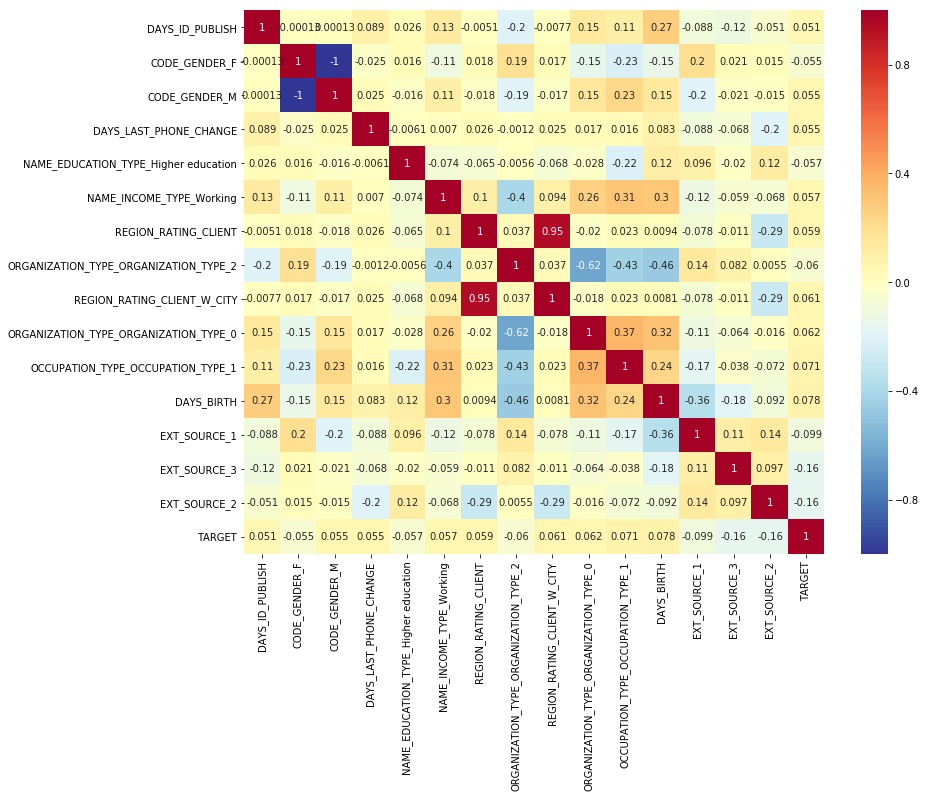

In [43]:
# Lấy ra danh sách 15 biến có tương quan lớn nhất tới biến mục tiêu theo trị tuyệt đối.
cols_corr_15 = np.abs(corr_tbl_train['TARGET']).sort_values()[-16:].index.tolist()

# Tính ma trận hệ số tương quan
cols_tbl_15 = pd_train[cols_corr_15].corr()

# Biểu diễn trên biểu đồ heatmap
plt.figure(figsize = (13, 10))
sns.heatmap(cols_tbl_15, cmap = plt.cm.RdYlBu_r, annot = True)

Phân phối xác xuất của các biến trên theo các nhóm của biến mục tiêu.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


<Figure size 1440x360 with 0 Axes>

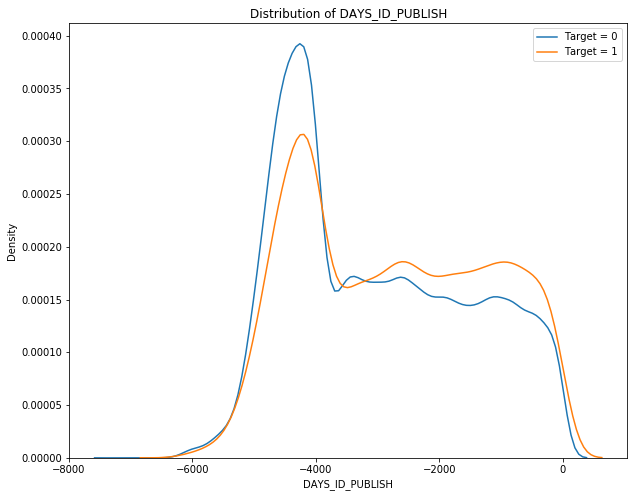

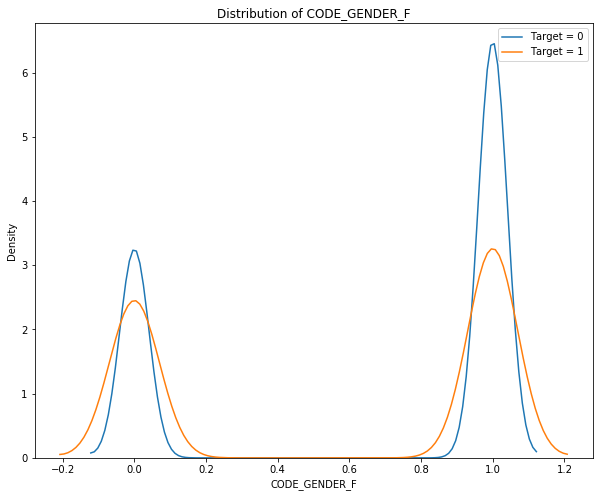

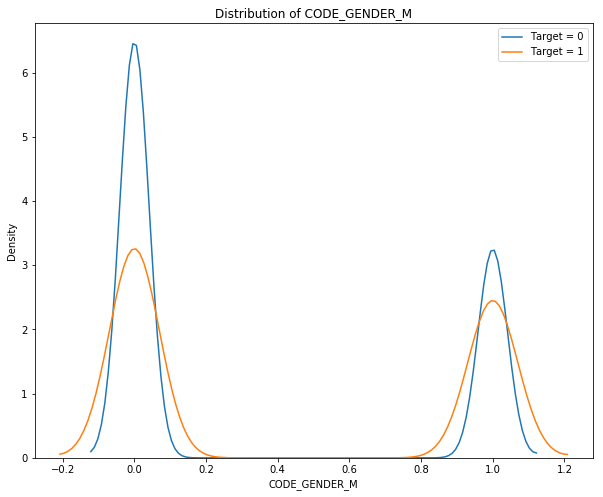

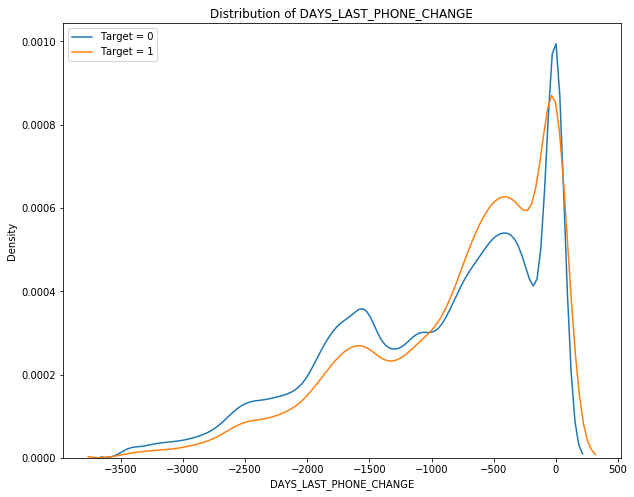

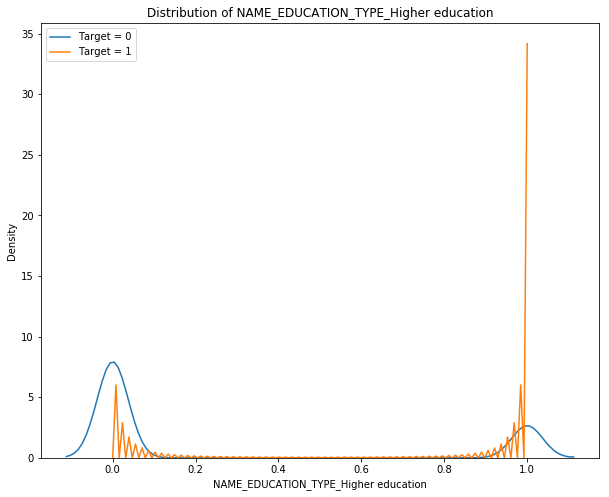

In [44]:
plt.figure(figsize = (20, 5))
for i in range(5):
    _plot_density(cols_corr_15[i])

DAYS_BIRTH là một biến liên tục có range nằm trong khoảng từ 20 - 70. Trục hoành biểu diễn độ tuổi theo ngày, giá trị âm thể hiện số ngày chênh lệch từ thời điểm sinh so với hiện tại. Như vậy người trẻ sẽ nằm ở bên phải của trục hoành và người già sẽ nằm bên trái. Từ biểu đồ ta có thể thấy những người trẻ có xu hướng không trả nợ nhiều hơn những người già. Bằng chứng là tại đồ thị mật độ ta nhận thấy phân phối lệch phải. Để làm rõ hơn nhận định, chúng ta đi tìm hiểu hành vi trả nợ theo các nhóm tuổi.

In [45]:
age_bin = app_train[['TARGET', 'DAYS_BIRTH']]
age_bin['YEAR_OLD'] = -app_train['DAYS_BIRTH']/365

# Phân chia khoảng tuổi thanh 10 khoảng bằng nhau
age_bin['DAYS_BIN'] = pd.cut(age_bin['YEAR_OLD'], bins = np.linspace(20, 70, num = 11))
age_bin.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,TARGET,DAYS_BIRTH,YEAR_OLD,DAYS_BIN
0,1,-9461,25.920548,"(25.0, 30.0]"
1,0,-16765,45.931507,"(45.0, 50.0]"
2,0,-19046,52.180822,"(50.0, 55.0]"
3,0,-19005,52.068493,"(50.0, 55.0]"
4,0,-19932,54.608219,"(50.0, 55.0]"


Thống kê số lượng không trả nợ theo các khoảng tuổi.

In [46]:
age_bin.groupby(['DAYS_BIN']).mean()

,TARGET,DAYS_BIRTH,YEAR_OLD
DAYS_BIN,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


Biểu đồ tỷ lệ trả nợ các hợp đồng theo từng nhóm tuổi.

Text(0.5,0,'Not Repaid rate')

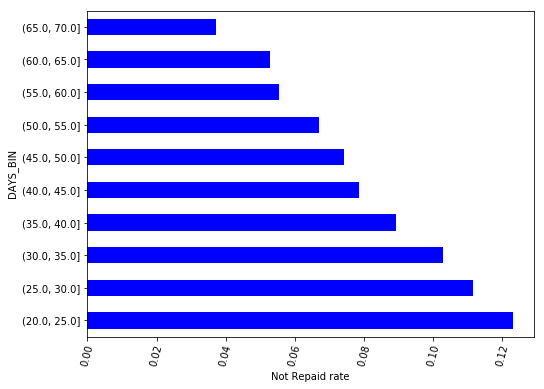

In [47]:
plt.figure(figsize = (8, 6))
age_bin.groupby(['DAYS_BIN']).mean()['TARGET'].plot.barh(color = 'b')
plt.xticks(rotation = '75')
plt.xlabel('Not Repaid rate')

Biểu đồ cho thấy tỷ lệ không trả nợ ở những người thuộc nhóm tuổi cao thấp hơn so với nhóm tuổi thấp. Hành vi này có thể là do người trẻ từ 20-25 tuổi chưa có thu nhập cao và các khoản tiết kiệm trong khi người gia có nhiều tiền tiết kiệm. 

Sau khi xử lý dữ liệu missing và tìm hiểu phân phối tỷ lệ Repaid/ Not Repaid của các biến numeric. Chúng ta sẽ hồi qui mô hình.

## 3.2. Logistic regression

Mặc dù tên mô hình là logistic regression nhưng logistic không phải là mô hình hồi qui mà trái lại, là mô hình thuộc lớp phân loại. Ngoài ra logistic không phải là một phương pháp mạnh. Đây là lớp mô hình có đường biên phân loại tuyến tính (linear seperable) nên khả năng phân loại dữ liệu trong trường hợp biên của các nhóm chồng lấn sẽ yếu. Tuy nhiên đây là phương pháp được sử dụng phổ biến nhất trong tính toán scorecard. Một trong những nguyên nhân giúp logistic được ưa chuộng trong scorecard đó là:

* Giá trị của logistic nằm giới hạn trong khoảng [0, 1] và phù hợp với miền giá trị mà một xác xuất rơi vào.
* Đạo hàm của hàm sigmoid rất đẹp mắt..
* Hàm mất mát là một hàm lồi.
* Có thể giải thích được tác động của các biến giải thích lên biến mục tiêu dựa vào hệ số ước lượng. Điều mà trường phái thống kê rất coi trọng.

Chính vì thế, khi làm quen với Machine Learning, hồi qui logistic sẽ là một trong những lớp bài toán được tiếp cận đầu tiên sau hồi qui tuyến tính. Bên dưới là mô hình hồi qui logistic áp dụng cho bài toán này.

In [48]:
from sklearn.linear_model import LogisticRegression

# Xây dựng mô hình logistic với tham số kiểm soát C = 0.0001
log_reg = LogisticRegression(C = 0.0001)

# Huấn luyện mô hình
log_reg.fit(train, TARGET)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [49]:
train_pred_prob = log_reg.predict_proba(train)[:, 1]

In [50]:
TARGET.value_counts()/TARGET.value_counts().sum()

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

ROC curve (Receiver Operating Characteristic) là một đường cong thể hiện mối liên hệ giữa tỷ lệ mắc sai lầm loại I (false positive rate) và tỷ lệ dự báo đúng positive (true positive rate). 

Trong thống kê, chúng ta chia các sai lầm của giả thuyết thành 2 loại: sai lầm loại I và sai lầm loại II. Khi thực hiện một mô hình phân loại nợ mục tiêu của chúng ta là tìm ra những hồ sơ nợ xấu. Một kết luận từ mô hình có thể rơi vào 2 trạng thái sai lầm: nhận định một hồ sơ xấu là tốt - loại I, hoặc trái lại, coi một hồ sơ tốt là xấu - loại II (giết nhầm còn hơn bỏ sót). 

Tác hại của sai lầm loại I sẽ lớn hơn sai lầm loại II bởi ảnh hưởng do hồ sơ xấu gây là lớn hơn nhiều so với việc bạn kiếm được một hồ sơ tốt. Đó cũng là lý do Tào Tháo thường hay đa nghi bởi ông biết được mức độ tác hại của 2 loại sai lầm này là khác nhau (mặc dù ông cũng chẳng có một chứng chỉ thống kê nào).

Nếu chúng ta chấp nhận một tỷ dự báo đúng hồ sơ tốt cao hơn thì chúng ta sẽ phải hạ thấp ngưỡng threshold xác định loại hồ sơ (mặc định là 0.5). Điều này dẫn đến các hồ sơ xấu có khả năng bị nhận định là hồ sơ tốt cao hơn. Điều này cho thấy luôn có sự đánh đổi giữa tỷ lệ true positive rate và false positive rate. 

Một mô hình phân loại tốt là mô hình mà ở các threshold ta phân loại được nhiều nhất các hồ sơ tốt nhưng chỉ phải chấp nhận một lượng rất nhỏ các hồ sơ xấu. Các mô hình như vậy đều có chung một tính chất, đó là đường cong ROC lồi lên phía trên so với trục hoành. Như vậy các bạn đã hiểu được ý nghĩa của đường cong ROC rồi chứ? Trên thực tiễn ROC là một biểu đồ trực quan đánh giá phẩm chất của mô hình. ROC càng lồi mô hình càng phân loại tốt và trái lại. Mức độ lồi của đường cong ROC được đo bằng phần diện tích nằm dưới đường cong ROC và trục hoành hay còn gọi là chỉ số AUC (Area under curve).

Trong tín dụng sau khi đã tìm được mô hình sở hữu đường cong ROC tốt nhất, ngân hàng sẽ xây dựng một hàm mất mát dựa trên phương trình ước lượng tổn thất:
$$EL = PD*LGD$$
Trong đó EL - Expected Loss, PD - Probability Default, LGD - Loss given default.

Để chọn ra một threshold tối ưu mang lại tổn thất về mặt lợi ích cho ngân hàng là nhỏ nhất. Về EL là gì? PD, LGD là gì? Mình sẽ không giải thích thêm ở bài viết này. Các bạn muốn đi sâu vào ngành Credit Risk có thể tìm thấy trong rất nhiều các tài liệu và khóa học về mảng đề tài này.

Bên dưới ta sẽ xây dựng một đường cong ROC.

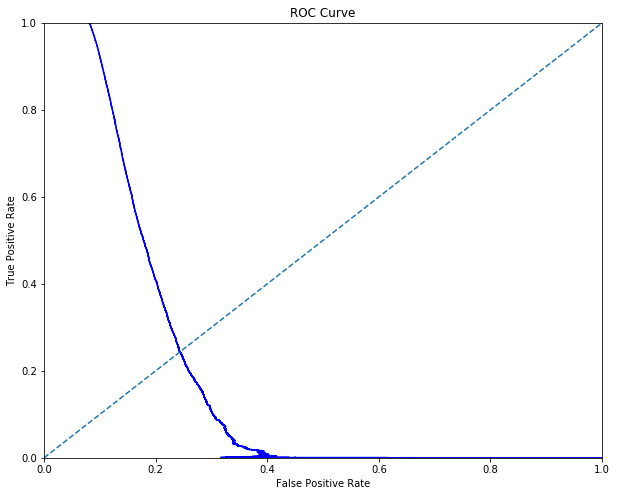

In [51]:
from sklearn.metrics import roc_curve, precision_recall_curve
fpr, tpr, thres = precision_recall_curve(TARGET, train_pred_prob)

def _plot_roc_curve(fpr, tpr, thres):
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', label = 'ROC')
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

_plot_roc_curve(fpr, tpr, thres)

Trong các mô hình phân loại chúng ta thường quan tâm đến tỷ lệ Accuracy. Đây là chỉ số đại diện nhất vì nó phản ánh trực tiếp hiệu quả của một mô hình thông qua số trường hợp phân loại đúng /tổng số trường hợp phân loại. Tuy nhiên chỉ số này tỏ ra kém hiệu quả đối với trường hợp mẫu mất cân bằng nghiêm trọng. Trong trường hợp này kết quả dự báo của mô hình thường thiên lệch về một lớp đa số. Do đó Accuracy hiển nhiên cao đối với những mô hình phẩm chất kém bởi số trường hợp hồ sơ tốt là quá nhiều dẫn đến một một mô hình cảm tính quyết định toàn bộ là hồ sơ tốt cũng dẫn tới Accuracy lớn. Một modeler thiếu kinh nghiệm sẽ rất dễ hài lòng với kết quả này. Nếu đưa vào áp dụng những mô hình như vậy sẽ ảnh hưởng không nhỏ tới các tổ chức tài chính, kinh doanh. Vậy trong trường hợp này tỷ lệ nào được sử dụng thay thể để đánh giá mô hình?
Precision và Recall là một lựa chọn thay thế phù hợp nhất bởi nó thỏa mãn các tính chất:

* Cả 2 đều đánh mức độ dự báo chính xác của positive tức hồ sơ phân loại là xấu. Đây là nhóm được ưu tiên phân loại chính xác hơn vì thiệt hại gây ra bởi nó lớn hơn.
* Precision đánh giá tỷ lệ dự báo chính xác hồ sơ xấu trong tổng số trường hợp được dự báo là xấu.
* Recall đánh giá tỷ lệ dự báo chính xác hồ sơ xấu khi hồ sơ về mặt bản chất là xấu.

Bên cạnh đó còn có các chỉ số khác chúng ta có thể cân nhắc như F1-Score, Kappa, Gini.

Khi nhìn vào biểu đồ của Precision và Recall ta sẽ biết được tại mỗi một ngưỡng threshold sẽ trả về tỷ lệ phân loại hồ sơ xấu là bao nhiêu trên lần lượt tổng số các hồ sơ được dự báo là xấu và tổng số các hồ sơ xấu trên thực tế.

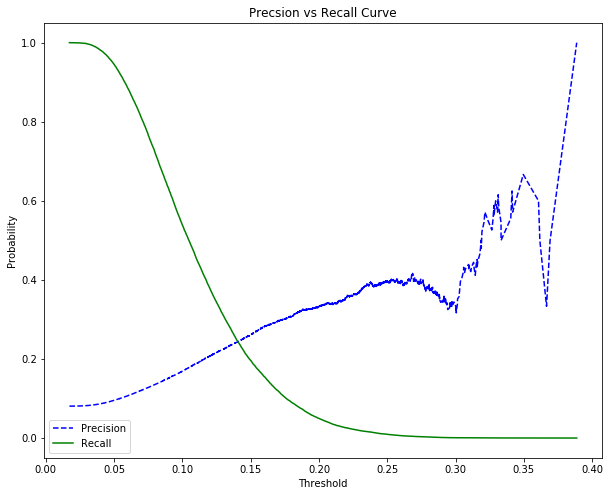

In [52]:
from sklearn.metrics import precision_recall_curve
prec, rec, thres = precision_recall_curve(TARGET, train_pred_prob)

def _plot_prec_rec_curve(prec, rec, thres):
    plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    plt.legend()

_plot_prec_rec_curve(prec, rec, thres)

Đường ROC curve không lồi lên phía trên so với trục hoành cho thấy sức mạnh phân loại của mô hình tương đối yếu. Tỷ lệ precision và recall theo các ngưỡng threshold cũng không phải là các đường cong lồi dẫn đến khi thay đổi threshold có thể làm tăng chi phí đánh đổi giữa tỷ lệ precision và recall đáng kể. Ở mỗi mức threshold không đạt được đồng thời tỷ lệ cao ở precision và recall. Thay vào đó ta sẽ phải đánh đổi giữa precision cao hoặc recall cao. Đây không phải là một mô hình đủ tốt để áp dụng vào thực tiễn.

## 3.3. Sử dụng kĩ thuật feature engineering

Hầu hết bí quyết để chiến thắng trong các cuộc thi phân tích dữ liệu đó là feature engineering. Feature engineering quan trọng đến mức thầy Andrew Ng đã nói rằng: 'Áp dụng học máy cơ bản là sử dụng feature engineering'. Và theo kinh nghiệm của mình, feature engineering thường mang lại kết quả tốt hơn so với các phương pháp hyparameter tunning. Tất nhiên sử dụng kết hợp cả 2 phương pháp này là tốt nhất nhưng mình vẫn thường có xu hướng thực hiện feature engineering trước khi lựa chọn các phương pháp phức tạp. Tránh tình trạng garbage in garbage out. Một mô hình phức tạp nhưng không có các biến đầu vào tin cậy thì kết quả mô hình sẽ không thể tốt.

Với mô hình hiện tại chúng ta nhận thấy các biến không đủ mạnh để tạo ra một kết quả chuẩn xác. Trong trường hợp này mình nghĩ ngay đến việc áp dụng feature engineering như một giải pháp cải thiện tình hình. feature engineering sẽ tạo ra những biến mới mà khả năng giải thích của nó sẽ tốt hơn đáng kể nếu áp dụng vào mô hình. 

Về kĩ thuật feature engineering chúng ta có 2 nhánh chính là:

* feature selection: lựa chọn các biến tốt nhất từ các biến đã có. Phương pháp này có thể dựa trên ranking của các feature theo các tiêu chí đánh giá sức mạnh hoặc dựa trên kinh nghiệm và hiểu biết về đề tài nghiên cứu.

* thêm mới: Tạo ra các feature mới từ các feature sẵn có. Các biến đổi có thể là scale, chuẩn hóa dữ liệu, sử dụng lũy thừa, logarith,....

Trong bài này mình sẽ sử dụng feature engineering theo phương pháp thêm mới bằng đa thức bậc cao (polynormal feature). Các biến được lựa chọn để feature chỉ bao gồm 15 biến có tương quan cao nhất. Bậc được lựa chọn cao nhất là 3. Thông qua polynormal feature các biến bậc cao và biến tích chéo sẽ được tạo thành. Chẳng hạn từ 2 biến EXT_SOURCE_1 và EXT_SOURCE_2 chúng ta có thể tạo ra EXT_SOURCE_1^2, EXT_SOURCE_2^2 và EXT_SOURCE_1xEXT_SOURCE_2.

Trong sklearn chúng ta có thể dễ dàng sử dụng kĩ thuật này thông qua hàm `PolynormialFeatures()`.

In [53]:
print(cols_corr_15)

['DAYS_ID_PUBLISH', 'CODE_GENDER_F', 'CODE_GENDER_M', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Working', 'REGION_RATING_CLIENT', 'ORGANIZATION_TYPE_ORGANIZATION_TYPE_2', 'REGION_RATING_CLIENT_W_CITY', 'ORGANIZATION_TYPE_ORGANIZATION_TYPE_0', 'OCCUPATION_TYPE_OCCUPATION_TYPE_1', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'TARGET']


In [54]:
from sklearn.preprocessing import PolynomialFeatures, Imputer, MinMaxScaler

# Khởi tạo các preprocessing. Trong đó inputer theo mean, minmax scaler theo khoảng 0, 1 và polynomial features bậc 3.
inputer = Imputer(strategy = 'mean')
minmax_scaler = MinMaxScaler(feature_range = (0, 1))
poly_engineer = PolynomialFeatures(degree = 3)

# Lấy các feature có tương quan lớn nhất đến biến mục tiêu từ app_train và app_test
TARGET = app_train[cols_corr_15[-1]]
train_poly_fea = app_train[cols_corr_15[:-1]]
test_poly_fea = app_test[cols_corr_15[:-1]]

# input dữ liệu missing
inputer = inputer.fit(train_poly_fea)
train_poly_fea = inputer.transform(train_poly_fea)
test_poly_fea = inputer.transform(test_poly_fea)

# Minmax scaler dữ liệu
minmax_scaler = minmax_scaler.fit(train_poly_fea)
train_poly_fea = minmax_scaler.transform(train_poly_fea)
test_poly_fea = minmax_scaler.transform(test_poly_fea)

print('train_poly_fea shape: ', train_poly_fea.shape)
print('test_poly_fea shape: ', test_poly_fea.shape)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


train_poly_fea shape:  (307511, 15)
test_poly_fea shape:  (48744, 15)


In [55]:
# Polynormial features dữ liệu
poly_engineer = poly_engineer.fit(train_poly_fea)
train_poly_fea = poly_engineer.transform(train_poly_fea)
test_poly_fea = poly_engineer.transform(test_poly_fea)

print('train_poly_fea shape: ', train_poly_fea.shape)
print('test_poly_fea shape: ', test_poly_fea.shape)

train_poly_fea shape:  (307511, 816)
test_poly_fea shape:  (48744, 816)


Sau feature engineering, số lượng các biến đã tăng từ 15 lên 816 biến. Chúng ta có thể xem danh sách các features được tạo mới như sau:

In [ ]:
features = poly_engineer.get_feature_names(input_features = cols_corr_15[:-1])
features[:10]

['1',
 'DAYS_ID_PUBLISH',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_INCOME_TYPE_Working',
 'REGION_RATING_CLIENT',
 'ORGANIZATION_TYPE_ORGANIZATION_TYPE_2',
 'REGION_RATING_CLIENT_W_CITY']

Để đánh giá liệu rằng sau khi thực hiện features engineering có giúp cải thiện kết quả hay không chúng ta thực hiện hồi qui logistic theo những features mới.

In [57]:
from sklearn.linear_model import LogisticRegression

# Xây dựng mô hình hồi qui logistic với tham số kiểm soát là C = 0.0001
lg_reg = LogisticRegression(C = 0.0001)
lg_reg.fit(train_poly_fea, TARGET)
lg_reg

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [58]:
# Dự báo xác xuất logistic
train_pred_prob = lg_reg.predict_proba(train_poly_fea)[:, 1]

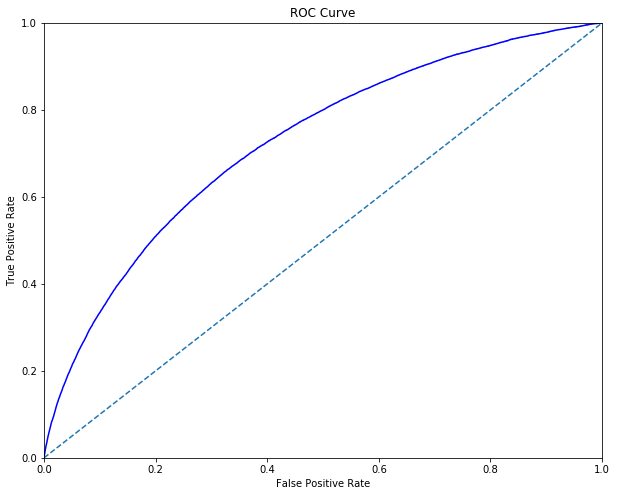

In [59]:
# Biểu diễn đường roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(TARGET, train_pred_prob)


def _plot_roc_curve(fpr, tpr, thres):
    roc = plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', label = 'ROC')
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    return roc

# Lưu biểu đồ vào p1
p1 = _plot_roc_curve(fpr, tpr, thres)

In [60]:
from sklearn.metrics import auc
#0.7127599620726505
auc(fpr, tpr)

0.7250041967217385

So với trước khi thực hiện feature engineering đường cong ROC sau khi thực hiện feature engineering lồi hơn. Điều đó cho thấy sức mạnh phân loại của mô hình tốt hơn sau feature engineering.

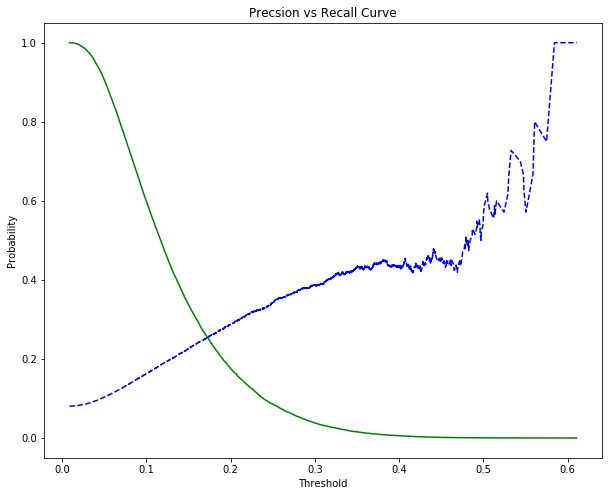

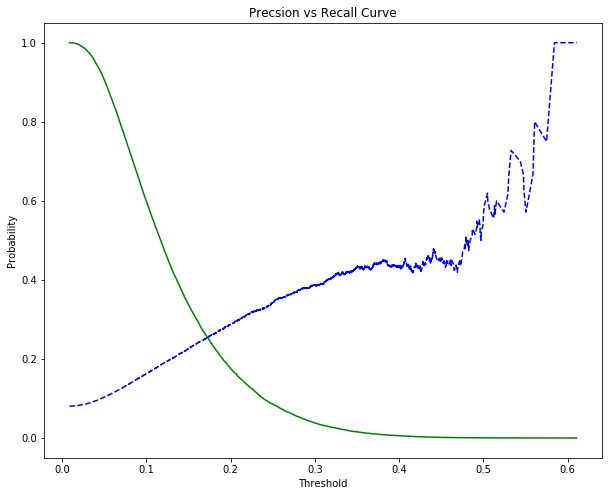

In [61]:
from sklearn.metrics import precision_recall_curve, accuracy_score

prec, rec, thres = precision_recall_curve(TARGET, train_pred_prob)

def _plot_prec_rec_curve(prec, rec, thres):
    plot_pr = plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    return plot_pr

_plot_prec_rec_curve(prec, rec, thres)

In [62]:
# Accuracy
train_pred_label = lg_reg.predict(train_poly_fea)
accuracy_score(TARGET, train_pred_label)

0.9192841882079015

## 3.4. Random Forest

Random Forest là mô hình thuộc lớp kết hợp (ensemble model) tức kết quả được đưa ra dựa trên không chỉ một mô hình mà từ nhiều mô hình khác nhau. 

Random Forest sẽ xây dựng một rừng cây ngẫu nhiên dựa trên các node và nhánh. Đại diện cho mỗi node là một câu hỏi mà giá trị trả về là YES hoặc NO. Các nhánh sẽ có tác dụng kết nối các nodes để tạo ra một kịch bản đường đi (routine).

Node bắt đầu của Random Forest là root node. Từ root node, mô hình sẽ xây dựng một bộ câu hỏi Yes/No dựa trên thông tin được cung cấp từ biến dự báo. Các nhánh YES, NO sẽ rẽ đến các node mới được gọi là internal node. Chẳng hạn đối với biến liên lục như YEAR_OLD mô hình có thể đặt ra câu hỏi YEAR_OLD > 30 hay không? Dựa trên giá trị của quan sát đối với biến YEAR_OLD mà một quan sát có thể rẽ theo nhánh YES hoặc NO. 

Tại phía cuối của các nhánh YES/NO mô hình tiếp tục khởi tạo những internal node ở tầng thấp hơn với các biến khác. Thứ tự các biến được lựa chọn là ngẫu nhiên. Quá trình rẽ nhánh được thực hiện liên tục cho đến khi mô hình đi đến node cuối. Tại node này không có nhánh nào được rẽ thêm. 

Sơ đồ của mô hình rất giống một cái cây. Xuất phát từ gốc cây rẽ vào các cành to, cành nhỏ và kết thúc ở lá. Bởi thế node cuối cùng còn được gọi là leaf node. Tại leaf node mô hình sẽ đưa ra kết quả thống kê của kịch bản đường đi (routine) từ gốc tới lá là một giá trị xác xuất của positive và negative. Mỗi một kịch bản rẽ nhánh từ root node tới leaf node được gọi là một cây.

Lưu ý rằng mỗi một cây được sẽ được áp dụng trên nhiều mẫu dữ liệu con được lựa chọn ngẫu nhiên để quyết định nhãn cho biến mục tiêu tại leaf node. Một quan sát được dự báo trên rất nhiều cây khác nhau và kết quả nhãn trả về từ các cây sẽ là cơ sở để voting nhãn cho quan sát.

Kết quả từ mô hình Random Forest được kết hợp từ nhiều cây quyết định con và được thử nghiệm trên nhiều bộ dữ liệu con nên sai số dự báo thông thường nhỏ hơn so với những mô hình phân loại tuyến tính như logistic hoặc linear regression. 

Bên cạnh Random Forest thì Gradient Boosting và AdaBoost cũng là các mô hình thuộc lớp mô hình kết hợp thường được áp dụng và mang lại hiệu quả bất ngờ tại nhiều cuộc thi.

Để sử dụng Random Forest trong python chúng ta có thể khai thác module `sklearn.ensemble`

In [63]:
from sklearn.ensemble import RandomForestClassifier

# Khởi tạo rừng cây
rd_classifier = RandomForestClassifier(n_estimators = 100, # Số cây trong rừng cây
                                       max_depth = 5, # Độ sâu của cây
                                       random_state = 123, # Khai báo seed để mô hình không đổi cho các lần chạy sau
                                       verbose = 1, # In log của quá trình huấn luyện
                                       n_jobs = -1 # Sử dụng đa luồng để vận hành mô hình
                                      )
rd_classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=123, verbose=1, warm_start=False)

In [64]:
# Huấn luyện mô hình
rd_classifier.fit(train_poly_fea, TARGET)

# Dự báo trên tập train
train_prob_rd = rd_classifier.predict_proba(train_poly_fea)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


Vẽ biểu đồ đường ROC curve

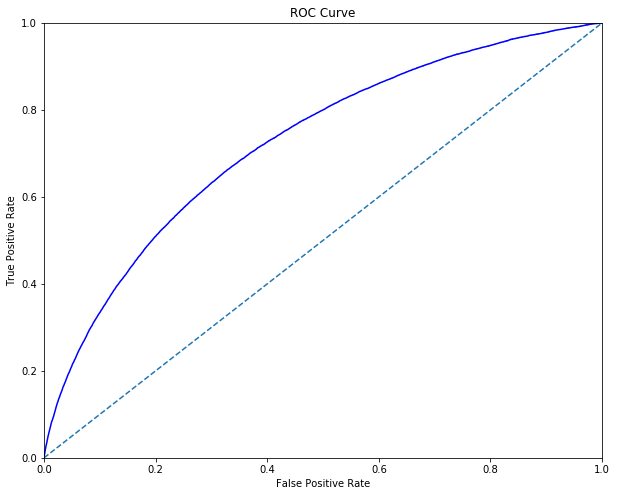

In [65]:
fpr2, tpr2, thres2 = roc_curve(TARGET, train_prob_rd)
p2 = _plot_roc_curve(fpr, tpr, thres)

Biểu diễn cả 2 đường ROC của hồi qui logistic và random forest trên cùng một đồ thị.

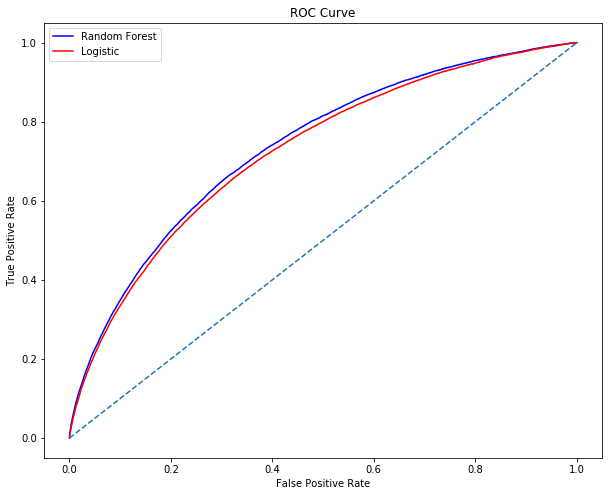

In [66]:
plt.figure(figsize = (10, 8))
plt.plot(fpr2, tpr2, 'b-', label = 'Random Forest')
plt.plot(fpr, tpr, 'r-', label = 'Logistic')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

In [67]:
from sklearn.metrics import auc
#0.7300858815170105
auc(fpr2, tpr2)

0.7358870860874754

Ta nhận thấy đường ROC của Random Forest lồi hơn so với Logistic. Điều đó cho thấy sức mạnh phân loại của Random Forest là tốt hơn Logistic.

Biểu đồ precision và recall curve

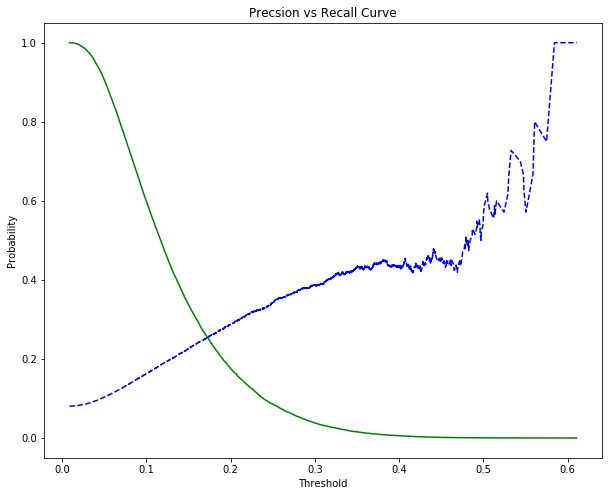

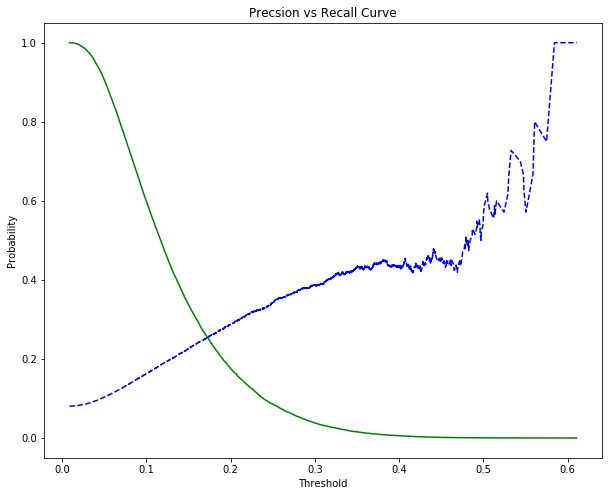

In [68]:
prec, rec, thres = precision_recall_curve(TARGET, train_pred_prob)
_plot_prec_rec_curve(prec, rec, thres)

Một trong những ưu thế của mô hình random forest đó là khả năng đánh giá mức độ quan trọng của các biến dự báo dựa trên mức độ ảnh hưởng của nó tới xác xuất của biến mục tiêu. Đây là một trong những phương pháp feature selection thường được sử dụng trong machine learning để tuyển chọn biến. Thông tin về mức độ quan trọng có thể được khai thác thông qua thuộc tính `feature_importances_` như sau:

In [69]:
# Lấy thông tin về mức độ quan trọng các biến tác động lên biến mục tiêu
feature_importance = rd_classifier.feature_importances_
feature_importance = pd.DataFrame({'importance values': feature_importance})
feature_importance.index = features
feature_importance = feature_importance.sort_values('importance values', ascending = False)
feature_importance[:10]

,importance values
EXT_SOURCE_1 EXT_SOURCE_3 EXT_SOURCE_2,0.067056
EXT_SOURCE_3^2 EXT_SOURCE_2,0.051051
EXT_SOURCE_3 EXT_SOURCE_2^2,0.050205
EXT_SOURCE_3 EXT_SOURCE_2,0.050187
EXT_SOURCE_1 EXT_SOURCE_3^2,0.040714
EXT_SOURCE_1 EXT_SOURCE_3,0.030020
EXT_SOURCE_2,0.029699
EXT_SOURCE_3^2,0.026576
DAYS_ID_PUBLISH EXT_SOURCE_3 EXT_SOURCE_2,0.024599
EXT_SOURCE_3,0.021123


Text(0.5,0,'Importance values')

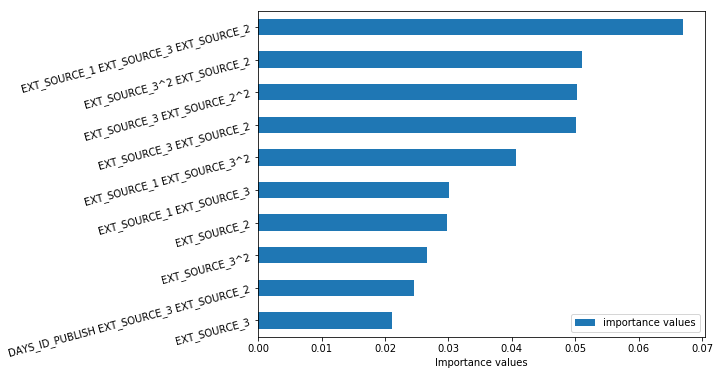

In [70]:
feature_importance[:10].sort_values('importance values', ascending = True).plot.barh(figsize = (8, 6))
plt.yticks(rotation = 15)
plt.xlabel('Importance values')

In [71]:
feature_importance.iloc[:5, 0].tolist()

[0.06705569408269753,
 0.05105069746191144,
 0.05020498926836052,
 0.05018692373035266,
 0.04071416916370789]

Tính toán mức độ chính xác của mô hình dự báo.

In [72]:
from sklearn.metrics import accuracy_score
train_label_rd = rd_classifier.predict(train_poly_fea)
accuracy_score(train_label_rd, TARGET)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


0.9192711805431351

In [73]:
np.unique(train_label_rd, return_counts = True)

(array([0]), array([307511]))

## 3.5. Gradient Boosting

In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

In [75]:
lgb_classifier = lgb.LGBMClassifier(n_estimator = 10000, 
                                    objective = 'binary', 
                                    class_weight = 'balanced',
                                    learning_rate = 0.05,
                                    reg_alpha = 0.1,
                                    reg_lambda = 0.1,
                                    subsample = 0.8,
                                    n_job = -1,
                                    random_state = 12
                                   )
lgb_classifier

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.05,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimator=10000, n_estimators=100, n_job=-1,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=12,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0)

In [76]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 12)
valid_scores = []
train_scores = []
count = 0
for train_idx, valid_idx in kfold.split(train_poly_fea):
    count += 1
    # Split train, valid
    train_features, train_labels = train_poly_fea[train_idx], TARGET[train_idx]
    valid_features, valid_labels = train_poly_fea[valid_idx], TARGET[valid_idx]
    lgb_classifier.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'], 
              early_stopping_rounds = 100, verbose = 200)
    
    valid_score = lgb_classifier.best_score_['valid']['auc'] 
    train_score = lgb_classifier.best_score_['train']['auc'] 
    
    valid_scores.append(valid_score)
    train_scores.append(train_score)
    
    print('fold time: {}; train score: {}; valid score: {}'.format(count, valid_score, train_score))

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[97]	valid's auc: 0.741921	valid's binary_logloss: 0.584965	train's auc: 0.764052	train's binary_logloss: 0.582694
fold time: 1; train score: 0.7419205654289209; valid score: 0.764051751371541
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid's auc: 0.746244	valid's binary_logloss: 0.586045	train's auc: 0.7641	train's binary_logloss: 0.582619
fold time: 2; train score: 0.7462437571708173; valid score: 0.7640999392822617
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[91]	valid's auc: 0.742415	valid's binary_logloss: 0.588127	train's auc: 0.762552	train's binary_logloss: 0.58393
fold time: 3; train score: 0.7424148283274947; valid score: 0.7625522540012919
Training until validation scores don't improve for 100 rounds.
Did not meet early stoppi

## 3.6. Neural network

In [77]:
# Deep learning với Keras
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Lambda
from keras.models import Model
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [78]:
train.shape

(307511, 171)

In [79]:
# design neural network
input_els = []
encode_els = []

# Generate a list include many Input layers

for i in range(train.shape[1]):
    # input alway have the shape (*, 1)
    input_els.append(Input(shape = (1,)))
    encode_els.append(input_els[-1])
# encode_els

In [80]:
# concate nate all layers
encode_els = concatenate(encode_els) 

# After completed the input layers, we design the hidden layers
hidden1 = Dense(units = 128, kernel_initializer = 'normal', activation = 'relu')(encode_els)
droplayer1 = Dropout(0.2)(hidden1)
hidden2 = Dense(64, kernel_initializer = 'normal', activation = 'relu')(droplayer1)
droplayer2 = Dropout(0.2)(hidden2)
outputlayer = Dense(1, kernel_initializer = 'normal', activation = 'sigmoid')(droplayer2)

classifier = Model(input = input_els, outputs = [outputlayer])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  # This is added back by InteractiveShellApp.init_path()


In [81]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

In [82]:
# split train/valid
from sklearn.model_selection import KFold
count = 0
kfold = KFold(n_splits = 10, shuffle = True, random_state = 12)
valid_scores = []
train_scores = []
for train_idx, valid_idx in kfold.split(train_poly_fea):
    while count < 1:
        count += 1
        # Split train, valid
        train_features, train_labels = train[train_idx], TARGET[train_idx]
        valid_features, valid_labels = train[valid_idx], TARGET[valid_idx]
        classifier.fit(
            [train_features[:, i] for i in range(train.shape[1])], #lấy list toàn bộ các cột
            train_labels,
            epochs=1,
            batch_size=128,
            shuffle=True,
            validation_data=([valid_features[:, i] for i in range(train.shape[1])], valid_labels) 
        )

Train on 276759 samples, validate on 30752 samples
Epoch 1/1
276759/276759 [==============================] - 17s 61us/step - loss: 0.2605 - acc: 0.9190 - val_loss: 0.2531 - val_acc: 0.9194


In [83]:
# DỰ báo trên tập train.
train_prob_nn = classifier.predict([train[:, i] for i in range(train.shape[1])])
train_prob_nn

array([[0.3661492 ],
       [0.0147081 ],
       [0.01426287],
       ...,
       [0.04720613],
       [0.05000718],
       [0.0580122 ]], dtype=float32)

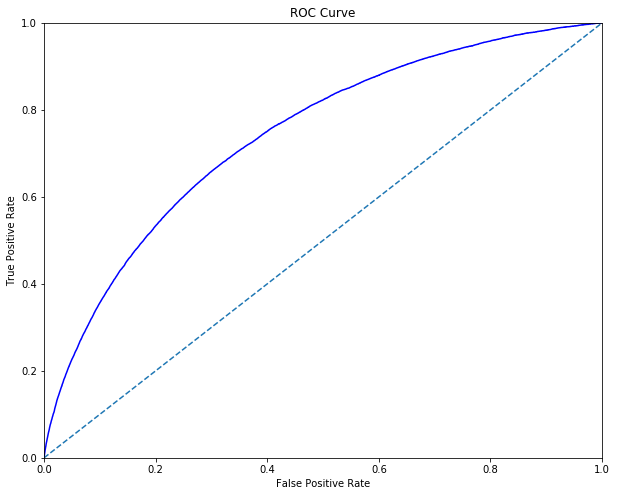

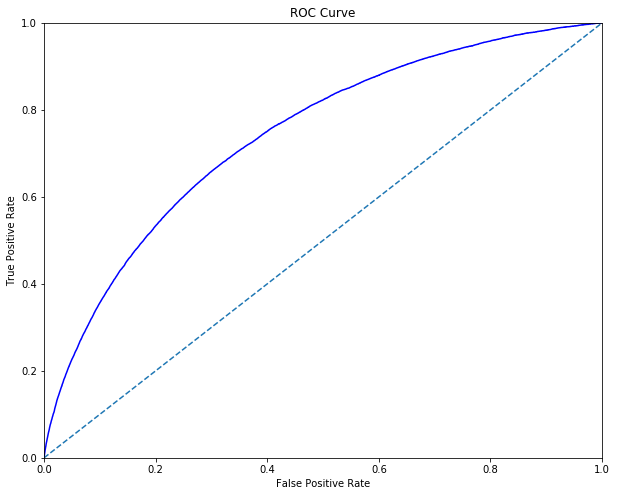

In [84]:
# np.save('train_prob_nn.npy',train_prob_nn)

fpr4, tpr4, thres4 = roc_curve(TARGET, train_prob_nn)
_plot_roc_curve(fpr4, tpr4, thres4)

In [85]:
from sklearn.metrics import auc
auc(fpr4, tpr4)

0.7421386058650338

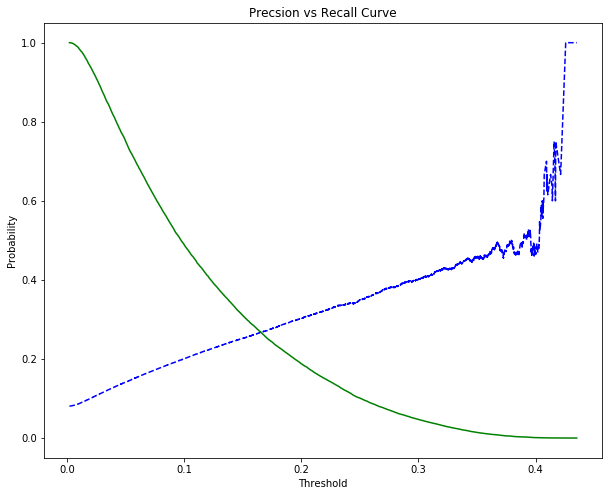

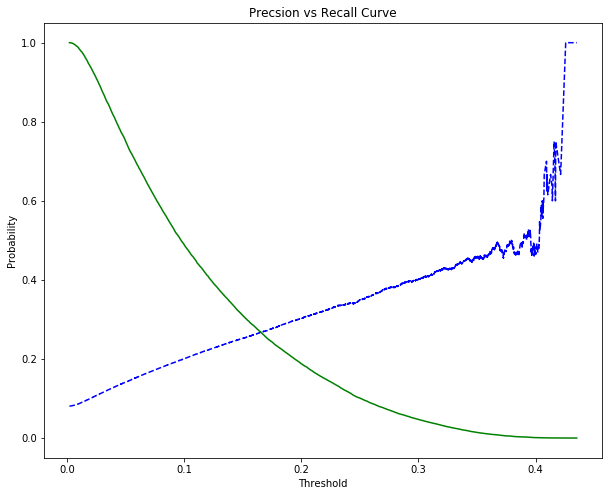

In [86]:
prec, rec, thres = precision_recall_curve(TARGET, train_prob_nn)
_plot_prec_rec_curve(prec, rec, thres)

In [87]:
# Save data
# np.save('train1.npy', train)
# np.save('test1.npy', test)
# np.save('TARGET.npy', TARGET)


In [88]:
# import numpy as np
# train = np.load('train.npy')
# print(train.shape)
# test = np.load('test.npy')
# print(test.shape)